# Tuolumne Boxplots

In [15]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
import hvplot.pandas
import pickle
from scipy import stats
from scipy.signal import savgol_filter
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
from matplotlib.lines import Line2D
#from datetime import datetime
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [9]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [10]:
mpl_epoch = '1970-01-01'

In [11]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

## Create File Paths to Snow On ASO Data for Rasterstats Calculations

In [12]:
aso_fn_winters = ['../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200413_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200522_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif']

In [13]:
# written by Hannah Besso, June 30, 2022

def build_stats(rasterstats):
    rasterstats = rasterstats[0]
    stats_dict = {'mean':rasterstats['mean'], 'iqr':(rasterstats['max']-rasterstats['min']), 'whishi':rasterstats['max'], 'whislo':rasterstats['min'], 'q1':rasterstats['percentile_25'], 'med':rasterstats['median'], 'q3':rasterstats['percentile_75'], 'count':rasterstats['count']}
    return stats_dict

def build_bp_stats(raster_list = None, region = None):
    dict_list = []
    pos = []
    count = []
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
        stats_dict = build_stats(rasterstats)
        dict_list.append(stats_dict)
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        pos.append((pd.to_datetime(date) - pd.to_datetime(mpl_epoch)).days)
        count.append(stats_dict['count'])

    count = np.array(count)
    return dict_list, pos, count

In [16]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

### Load in the saved data:

In [16]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks/figure_production


In [33]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
atl06sr_gdf_cdec = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

In [37]:
atl06sr_gdf_cdec.head(2)

distance   h_sigma  rgt    delta_time  \
time                                                                       
2018-10-15 23:22:20.018965444  4.215353e+06  0.033182  265  2.488094e+07   
2018-10-15 23:22:20.021811344  4.215373e+06  0.028329  265  2.488094e+07   

                               pflags  dh_fit_dy  segment_id  \
time                                                           
2018-10-15 23:22:20.018965444       0        0.0      210188   
2018-10-15 23:22:20.021811344       0        0.0      210189   

                               w_surface_window_final  dh_fit_dx       h_mean  \
time                                                                            
2018-10-15 23:22:20.018965444                     3.0  -0.018228  2501.377184   
2018-10-15 23:22:20.021811344                     3.0  -0.010939  2501.116873   

                               spot  gt  cycle  rms_misfit  n_fit_photons  \
time                                                                        
2018-10-15 23:22:20.018965444     4  30      1    0.091912             15   
2018-10-15 23:22:20.021811344     4  30      1    0.109110             18   

                                                     geometry  doy  \
time                                                                 
2018-10-15 23:22:20.018965444  POINT (269304.074 4196719.705)  288   
2018-10-15 23:22:20.021811344  POINT (269302.684 4196739.709)  288   

                                   decyear  dowy snow_presence      site  \
time                                                                       
2018-10-15 23:22:20.018965444  2018.788969    15             0  tuolumne   
2018-10-15 23:22:20.021811344  2018.788969    15             0  tuolumne   

                                  acqdate      lidar_z  difference  \
time                                                                 
2018-10-15 23:22:20.018965444  2018-10-15  2501.669922   -0.292738   
2018-10-15 23:22:20.021811344  2018-10-15  2501.169922   -0.053049   

                               lidar_z_20m  difference_20m  slope_3m  \
time                                                                   
2018-10-15 23:22:20.018965444  2501.780029       -0.402845  1.725123   
2018-10-15 23:22:20.021811344  2501.500000       -0.383127  4.888882   

                               slope_20m  slope_100m  diff_plus  \
time                                                              
2018-10-15 23:22:20.018965444   1.438880         NaN   -0.17767   
2018-10-15 23:22:20.021811344   2.426852         NaN    0.06202   

                               diff_plus_20m  ASO_snowon ASO_snowon_date  \
time                                                                       
2018-10-15 23:22:20.018965444      -0.269368         NaN             NaN   
2018-10-15 23:22:20.021811344      -0.249650         NaN             NaN   

                               ASO_snowon_20m  
time                                           
2018-10-15 23:22:20.018965444             NaN  
2018-10-15 23:22:20.021811344             NaN

In [36]:
atl06sr_gdf['tum_depth'] = atl06sr_gdf_cdec['tum_depth']

KeyError: 'tum_depth'

In [18]:
snow_columns = ['tum_m', 'dan_clean']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dt_min_plot' is not defined

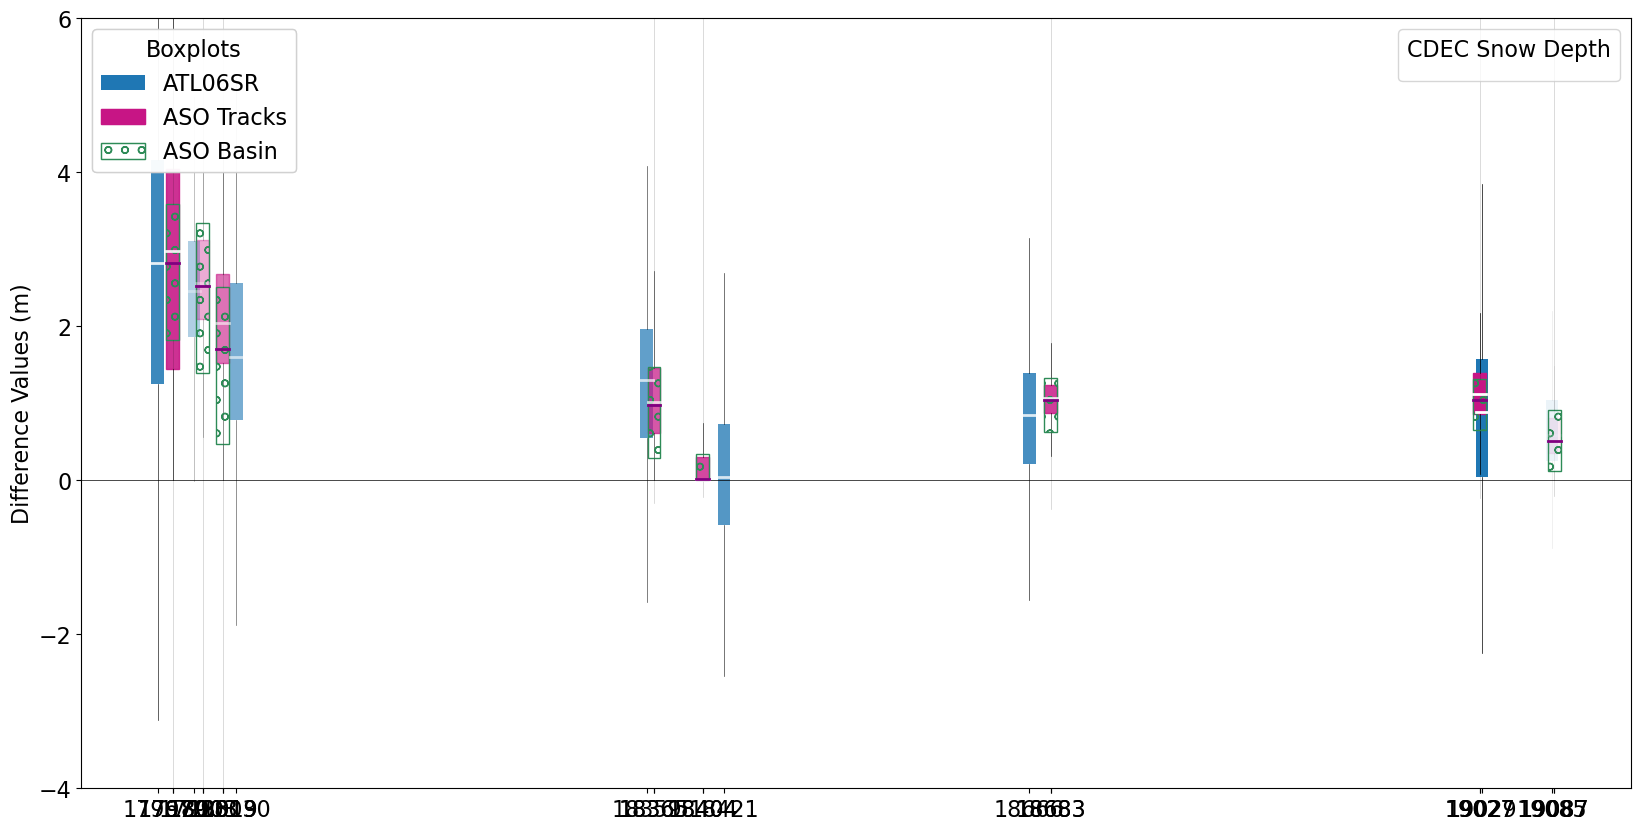

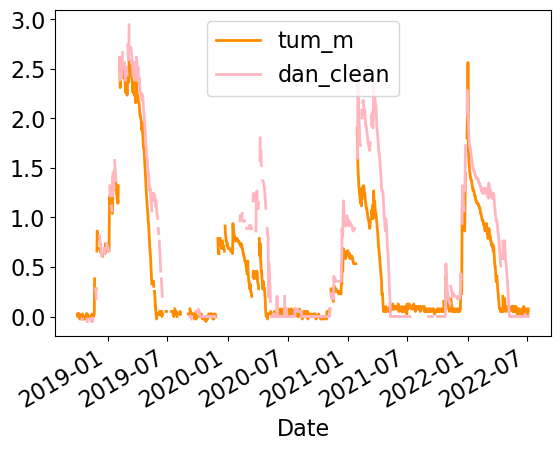

In [20]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', snow_df=snwd, snow_columns=snow_columns, region_aso=outline_gdf, rasterstats=True, snowon_list=aso_fn_winters, clim=(-4,6))

## Create Transparent Boxplots

Playing with parameters to see how each piece works:

In [17]:
bp_stats = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').apply(cbook.boxplot_stats)
bp_stats_list = [i[0] for i in bp_stats.values]
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = bp_alpha/bp_alpha.max()
pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values

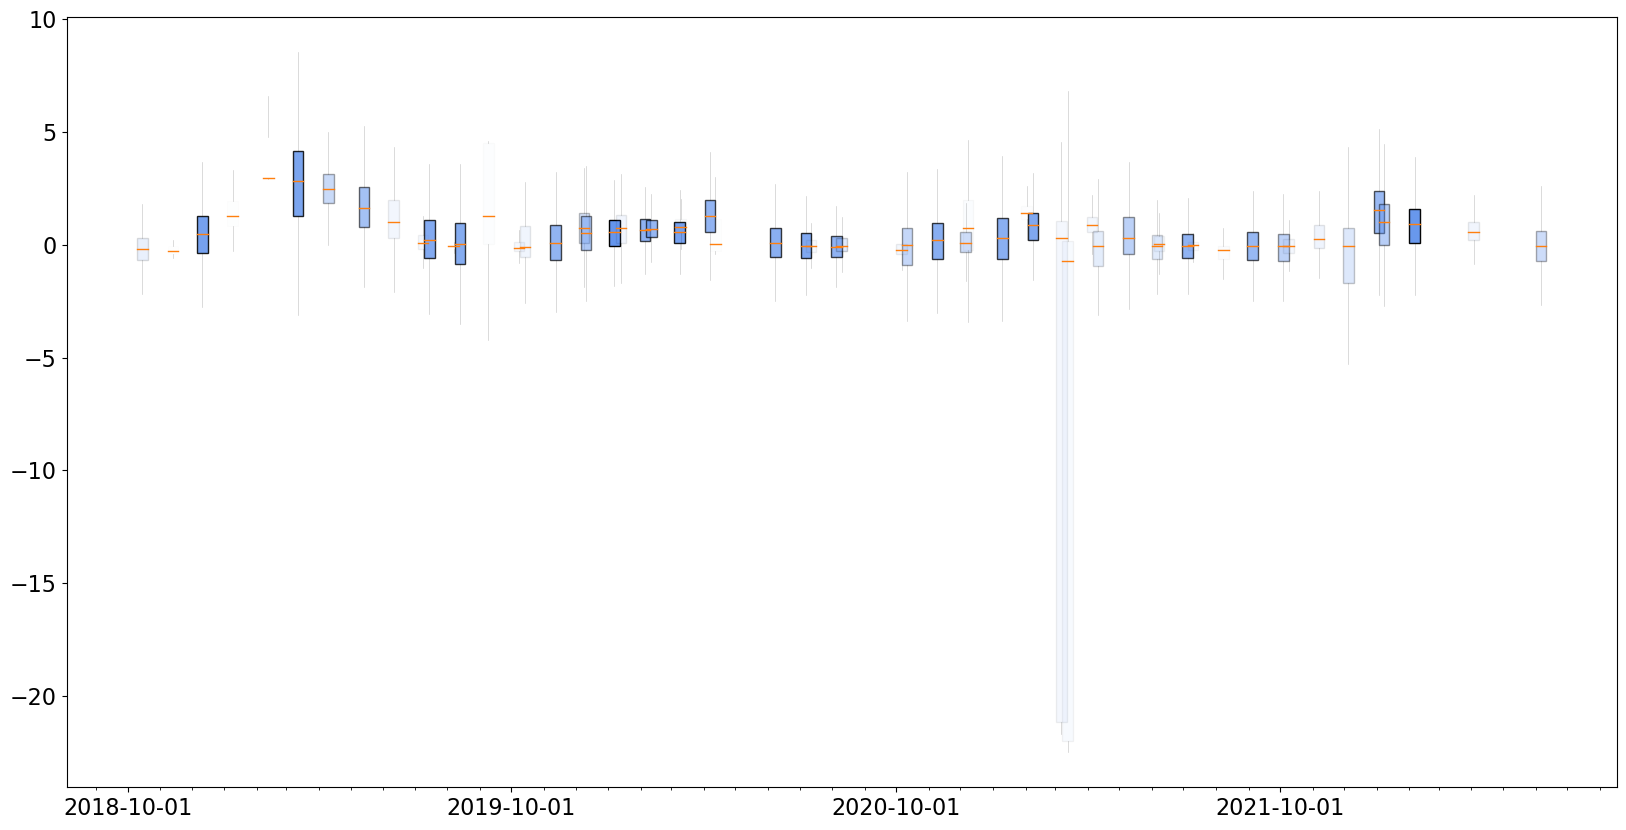

In [18]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'

f, ax = plt.subplots(figsize=(20,10))
bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, widths=10, patch_artist=True)

for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
    patch.set_alpha(alpha)
    patch.set_facecolor('cornflowerblue')

years = mdates.YearLocator(month=10)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
months = mdates.MonthLocator()
ax.xaxis.set_minor_locator(months)

### Transparent Boxplots with CDEC and ATL06SR Data

In [17]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    # months = mdates.MonthLocator()
    # ax.format_xdata = mdates.DateFormatter('%m')
    # months_fmt = mdates.DateFormatter('%m')
    # ax.xaxis.set_major_locator(months)
    # ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}', dpi=500)

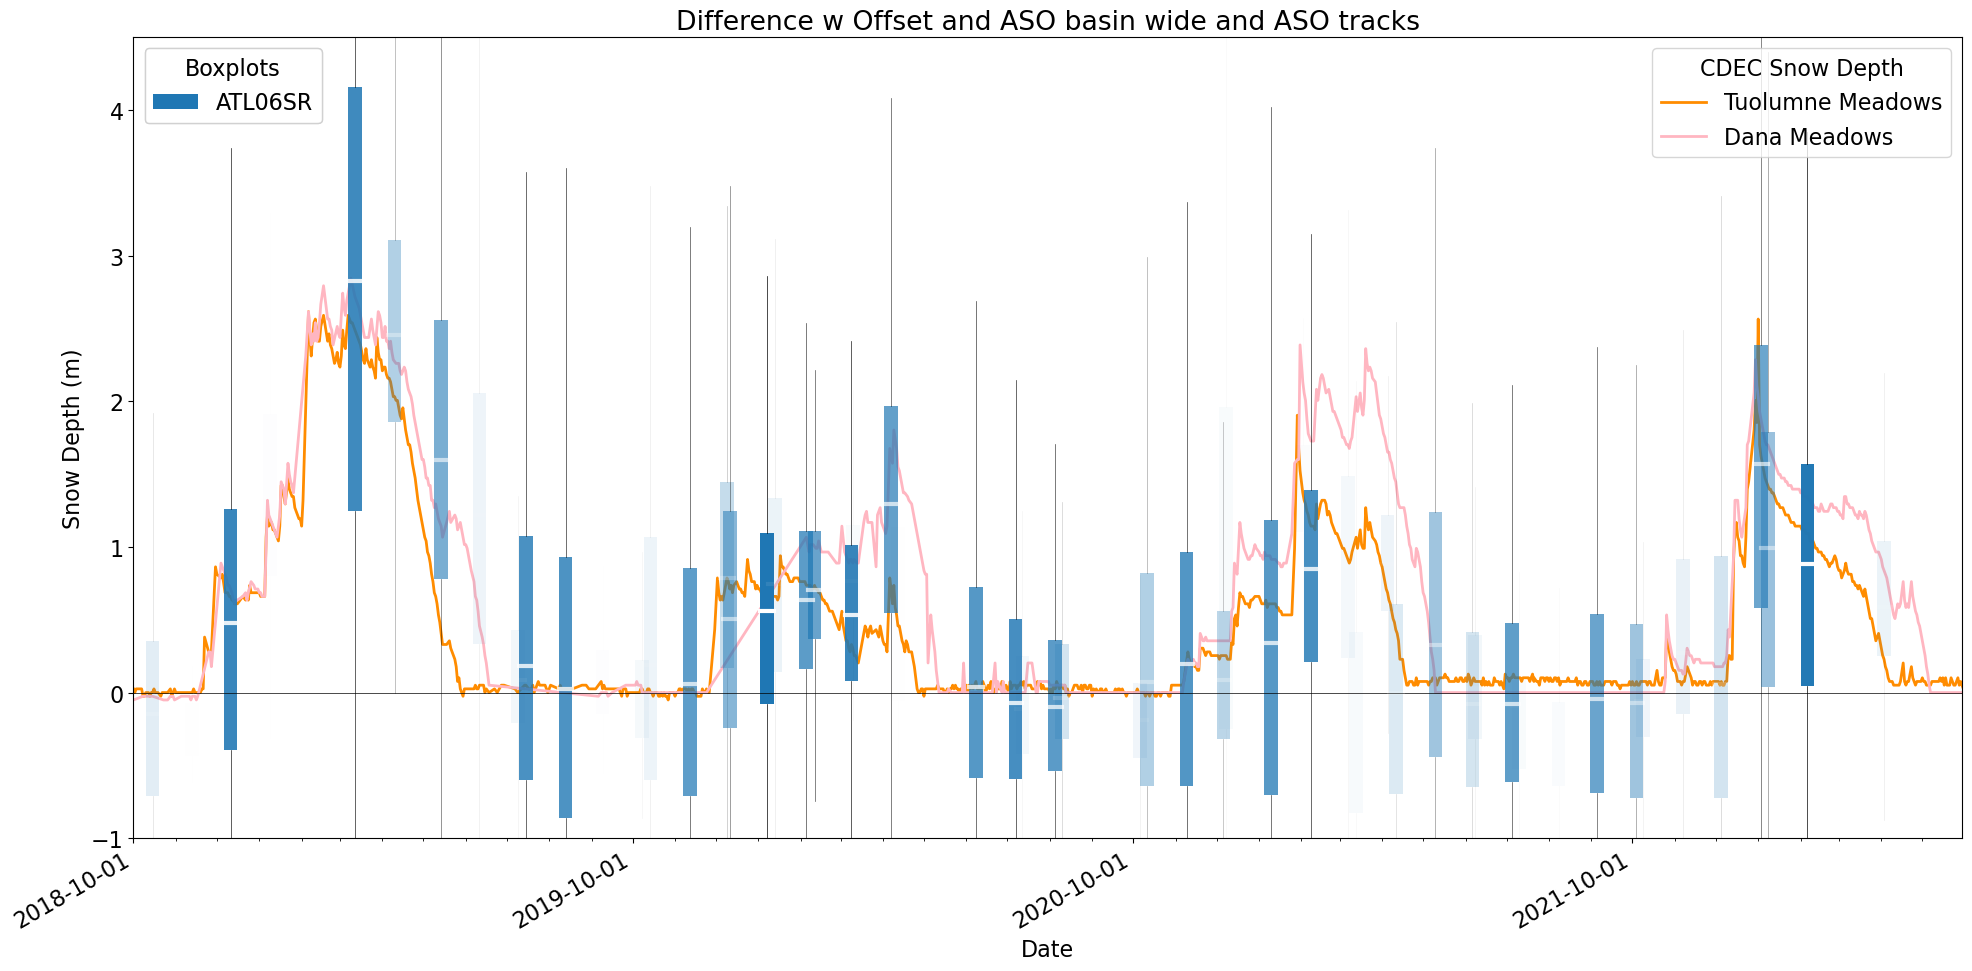

In [22]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,4.5), name = 'boxplots_atl06sr_transparent.jpeg')

In [25]:
atl06sr_gdf.head(2)

distance   h_sigma  rgt    delta_time  \
time                                                                       
2018-10-15 23:22:20.018965444  4.215353e+06  0.033182  265  2.488094e+07   
2018-10-15 23:22:20.021811344  4.215373e+06  0.028329  265  2.488094e+07   

                               pflags  dh_fit_dy  segment_id  \
time                                                           
2018-10-15 23:22:20.018965444       0        0.0      210188   
2018-10-15 23:22:20.021811344       0        0.0      210189   

                               w_surface_window_final  dh_fit_dx       h_mean  \
time                                                                            
2018-10-15 23:22:20.018965444                     3.0  -0.018228  2501.377184   
2018-10-15 23:22:20.021811344                     3.0  -0.010939  2501.116873   

                               spot  gt  cycle  rms_misfit  n_fit_photons  \
time                                                                        
2018-10-15 23:22:20.018965444     4  30      1    0.091912             15   
2018-10-15 23:22:20.021811344     4  30      1    0.109110             18   

                                                     geometry  doy  \
time                                                                 
2018-10-15 23:22:20.018965444  POINT (269304.074 4196719.705)  288   
2018-10-15 23:22:20.021811344  POINT (269302.684 4196739.709)  288   

                                   decyear  dowy snow_presence      site  \
time                                                                       
2018-10-15 23:22:20.018965444  2018.788969    15             0  tuolumne   
2018-10-15 23:22:20.021811344  2018.788969    15             0  tuolumne   

                                  acqdate      lidar_z  difference  \
time                                                                 
2018-10-15 23:22:20.018965444  2018-10-15  2501.669922   -0.292738   
2018-10-15 23:22:20.021811344  2018-10-15  2501.169922   -0.053049   

                               lidar_z_20m  difference_20m  slope_3m  \
time                                                                   
2018-10-15 23:22:20.018965444  2501.780029       -0.402845  1.725123   
2018-10-15 23:22:20.021811344  2501.500000       -0.383127  4.888882   

                               slope_20m  slope_100m  diff_plus  \
time                                                              
2018-10-15 23:22:20.018965444   1.438880         NaN   -0.17767   
2018-10-15 23:22:20.021811344   2.426852         NaN    0.06202   

                               diff_plus_20m  ASO_snowon ASO_snowon_date  \
time                                                                       
2018-10-15 23:22:20.018965444      -0.269368         NaN             NaN   
2018-10-15 23:22:20.021811344      -0.249650         NaN             NaN   

                               ASO_snowon_20m  
time                                           
2018-10-15 23:22:20.018965444             NaN  
2018-10-15 23:22:20.021811344             NaN

(-20.0, 20.0)

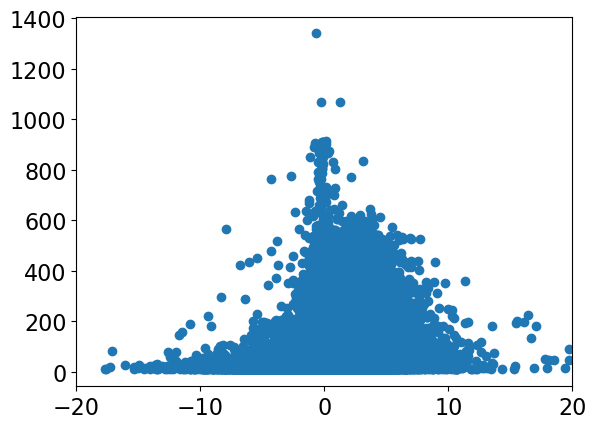

In [31]:
fig, ax = plt.subplots()

plt.scatter(atl06sr_gdf['diff_plus'], atl06sr_gdf['n_fit_photons'])
plt.xlim(-20,20)

In [48]:
# For presentation



boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None')]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    

custom_labels = ['ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR', 'Basin ALS Median', 'Basin ALS Basin IQR',]

In [50]:
# For paper

boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None')]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '20'
custom_labels = ['ATL06SR Median', 'ATL06SR IQR', 'Sampled ASO Median', 'Sampled ASO IQR', 'Basin SO Median', 'Basin ASO Basin IQR',]

In [36]:
stats_dict = build_bp_stats(aso_fn_winters, outline_gdf)

In [32]:
# Function adapted from David Shean by Hannah Besso
# No transparency

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(15,7))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
                    medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
                        medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        #patch.set_facecolor('#3BA795')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('#117733')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('#882255')
            patch.set_edgecolor('none')
            patch.set_alpha(0.5)
            #patch.set_hatch('o')
    #ax.set_title('Upper Tuolumne River Basin')
    
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        #patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        #patch.set_alpha(alpha)
        patch.set_color('k')  # or deeppink  
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_xlabel('Acquisition Date')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    #ax.set_title(title) 
    
    if (datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')).days <= 366:
        months = mdates.MonthLocator()
        #ax.format_xdata = mdates.DateFormatter('%B')
        months_fmt = mdates.DateFormatter('%B')
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(months_fmt)
        months = mdates.MonthLocator()
        ax.set_xlabel('2019 Acquisition Date')
        ax.legend(custom, custom_labels, loc='lower left', prop={'size':18}) #, fontsize=10

    else:
        years = mdates.YearLocator(month=4)
        years_fmt = mdates.DateFormatter('%B %d %Y')
        #ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
        #years_fmt = mdates.DateFormatter('%d-%m-%Y')
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)
        months = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(months)
        ax.legend(custom, custom_labels, loc='lower left', bbox_to_anchor=(0.25,0.65), prop={'size':18}) #, fontsize=10
    
    for label in ax.get_xticklabels(which='major'): #
        label.set(rotation=10, horizontalalignment='right')
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [60]:
from datetime import datetime
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
datetime.strptime(dt_max_plot, '%Y-%m-%d') - datetime.strptime(dt_min_plot, '%Y-%m-%d')

datetime.timedelta(days=364)

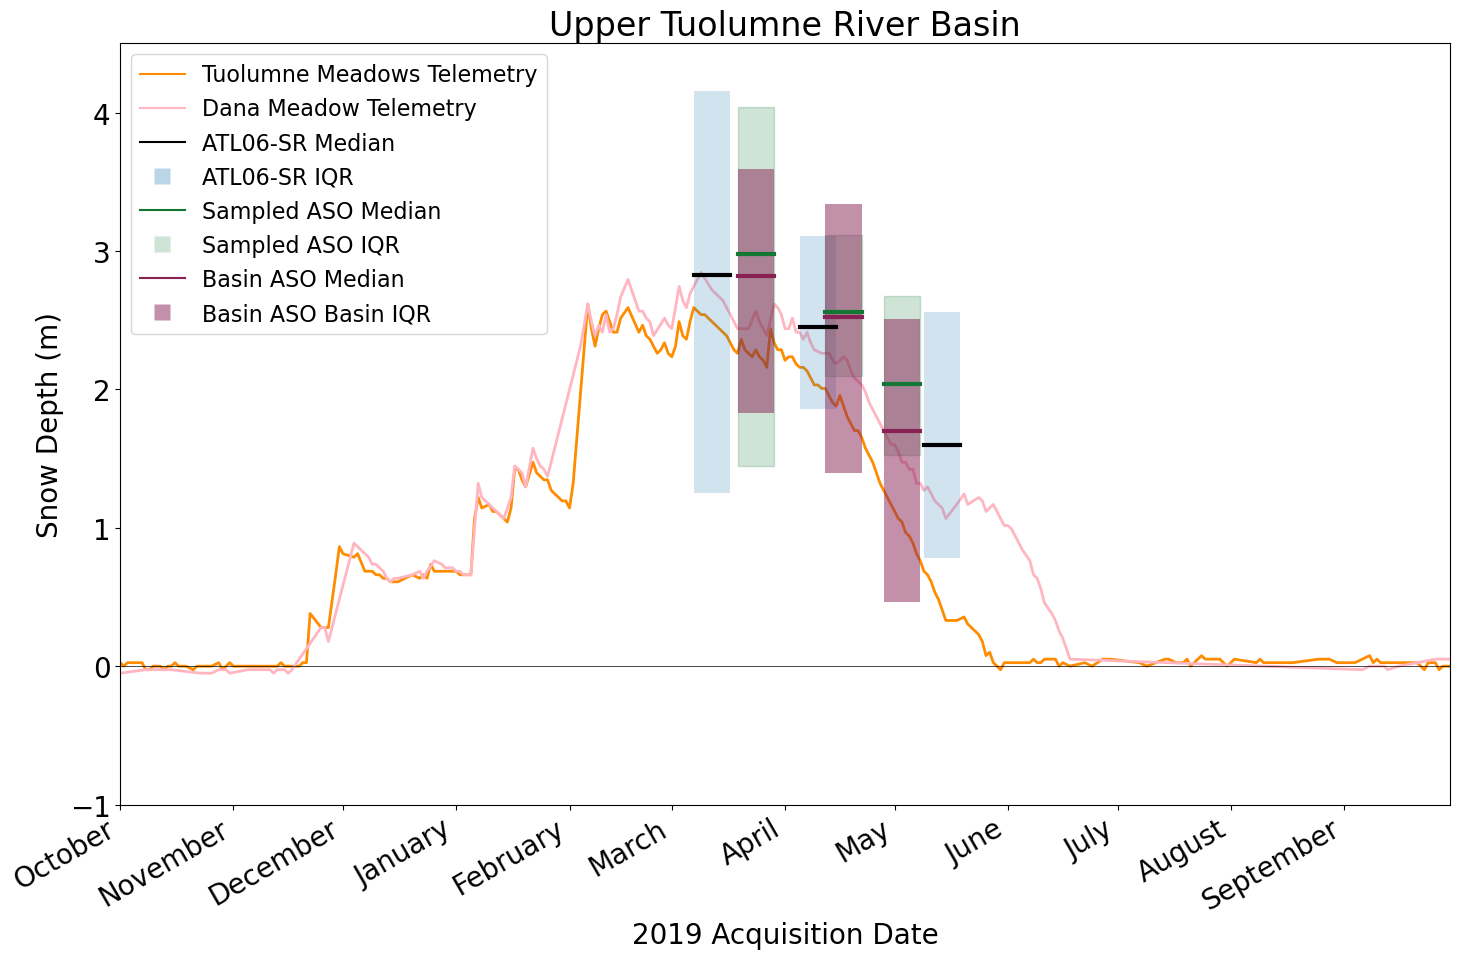

In [42]:
# For paper
from datetime import datetime
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='#117733'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='#882255'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None')
          ]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '20'
custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry','ATL06-SR Median', 'ATL06-SR IQR', 'Sampled ASO Median', 'Sampled ASO IQR', 'Basin ASO Median', 'Basin ASO Basin IQR',]

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4.5), name = 'boxplots_asotracks_basin_2019_paper')

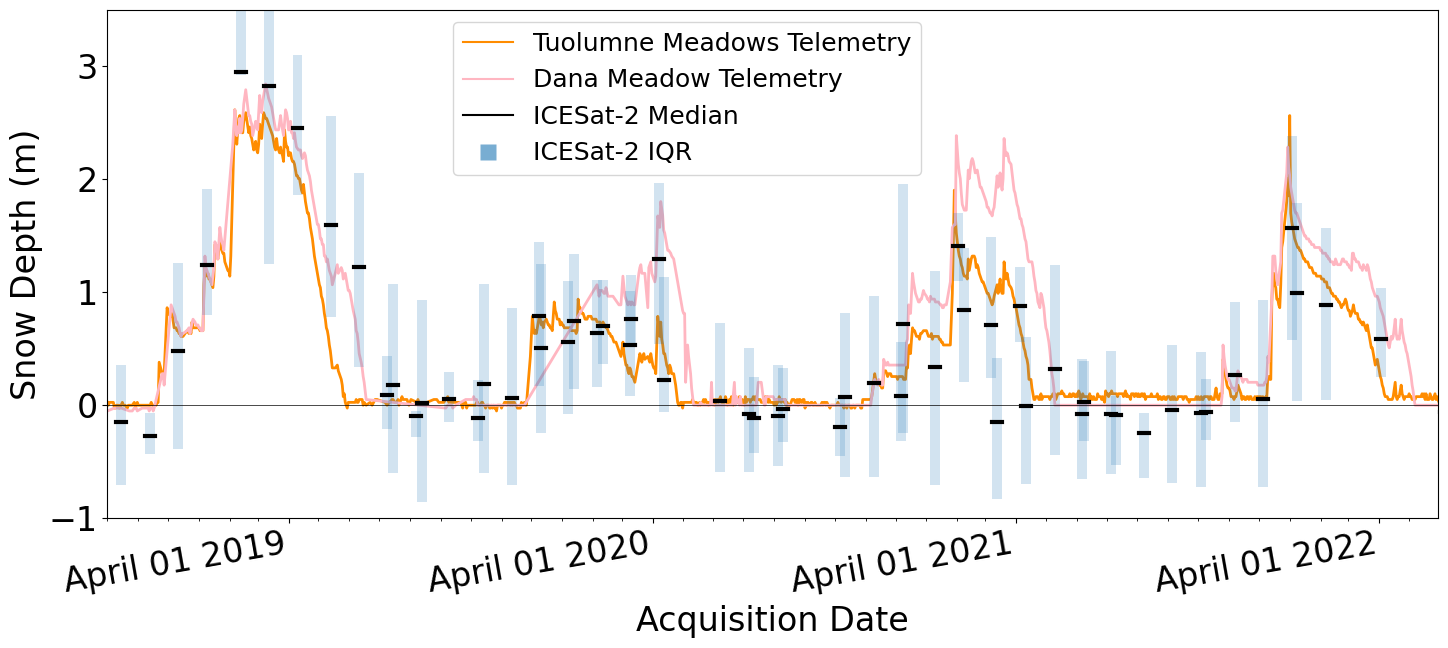

In [33]:
# For paper

boxplot_color = (31/255,119/255, 180/255, 0.6)

custom = [Line2D([], [], linestyle='-', linewidth=1.5, color='darkorange'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='lightpink'),
          Line2D([], [], linestyle='-', linewidth=1.5, color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None')
          ]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    
plt.rcParams['font.size'] = '24'
custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry','ICESat-2 Median', 'ICESat-2 IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,3.5), name = 'boxplots_asotracks_basin_proposal')

In [49]:
atl06sr_gdf.tail()

distance   h_sigma   rgt    delta_time  \
time                                                                        
2022-06-06 07:52:14.166292256  4.221955e+06  0.103436  1149  1.397371e+08   
2022-06-06 07:52:14.174719728  4.222015e+06  0.101625  1149  1.397371e+08   
2022-06-06 07:52:14.177525200  4.222035e+06  0.093427  1149  1.397371e+08   
2022-06-06 07:52:14.183137424  4.222075e+06  0.120022  1149  1.397371e+08   
2022-06-06 07:52:14.185946192  4.222095e+06  0.141535  1149  1.397371e+08   

                               pflags  dh_fit_dy  segment_id  \
time                                                           
2022-06-06 07:52:14.166292256       0        0.0      210520   
2022-06-06 07:52:14.174719728       0        0.0      210523   
2022-06-06 07:52:14.177525200       0        0.0      210524   
2022-06-06 07:52:14.183137424       0        0.0      210526   
2022-06-06 07:52:14.185946192       0        0.0      210527   

                               w_surface_window_final  dh_fit_dx       h_mean  \
time                                                                            
2022-06-06 07:52:14.166292256                8.424878  -0.329516  3501.549246   
2022-06-06 07:52:14.174719728                9.093066  -0.355783  3483.510153   
2022-06-06 07:52:14.177525200               10.206696  -0.399543  3476.005923   
2022-06-06 07:52:14.183137424                9.441717  -0.369486  3462.032878   
2022-06-06 07:52:14.185946192               10.012953  -0.391932  3454.424594   

                               spot  gt  cycle  rms_misfit  n_fit_photons  \
time                                                                        
2022-06-06 07:52:14.166292256     2  20     15    0.458372             21   
2022-06-06 07:52:14.174719728     2  20     15    0.448697             29   
2022-06-06 07:52:14.177525200     2  20     15    0.374106             26   
2022-06-06 07:52:14.183137424     2  20     15    0.367088             10   
2022-06-06 07:52:14.185946192     2  20     15    0.529541             14   

                                                     geometry  doy  \
time                                                                 
2022-06-06 07:52:14.166292256  POINT (299169.804 4201028.294)  157   
2022-06-06 07:52:14.174719728  POINT (299164.918 4201088.254)  157   
2022-06-06 07:52:14.177525200  POINT (299163.246 4201108.237)  157   
2022-06-06 07:52:14.183137424  POINT (299159.925 4201148.207)  157   
2022-06-06 07:52:14.185946192  POINT (299158.247 4201168.190)  157   

                                   decyear  dowy snow_presence      site  \
time                                                                       
2022-06-06 07:52:14.166292256  2022.428296   249             0  tuolumne   
2022-06-06 07:52:14.174719728  2022.428296   249             0  tuolumne   
2022-06-06 07:52:14.177525200  2022.428296   249             0  tuolumne   
2022-06-06 07:52:14.183137424  2022.428296   249             0  tuolumne   
2022-06-06 07:52:14.185946192  2022.428296   249             0  tuolumne   

                                  acqdate  lidar_z  difference  lidar_z_20m  \
time                                                                          
2022-06-06 07:52:14.166292256  2022-06-06      NaN         NaN          NaN   
2022-06-06 07:52:14.174719728  2022-06-06      NaN         NaN          NaN   
2022-06-06 07:52:14.177525200  2022-06-06      NaN         NaN          NaN   
2022-06-06 07:52:14.183137424  2022-06-06      NaN         NaN          NaN   
2022-06-06 07:52:14.185946192  2022-06-06      NaN         NaN          NaN   

                               difference_20m  slope_3m  slope_20m  \
time                                                                 
2022-06-06 07:52:14.166292256             NaN       NaN        NaN   
2022-06-06 07:52:14.174719728             NaN       NaN        NaN   
2022-06-06 07:52:14.177525200             NaN       NaN        NaN   
2022-06-06

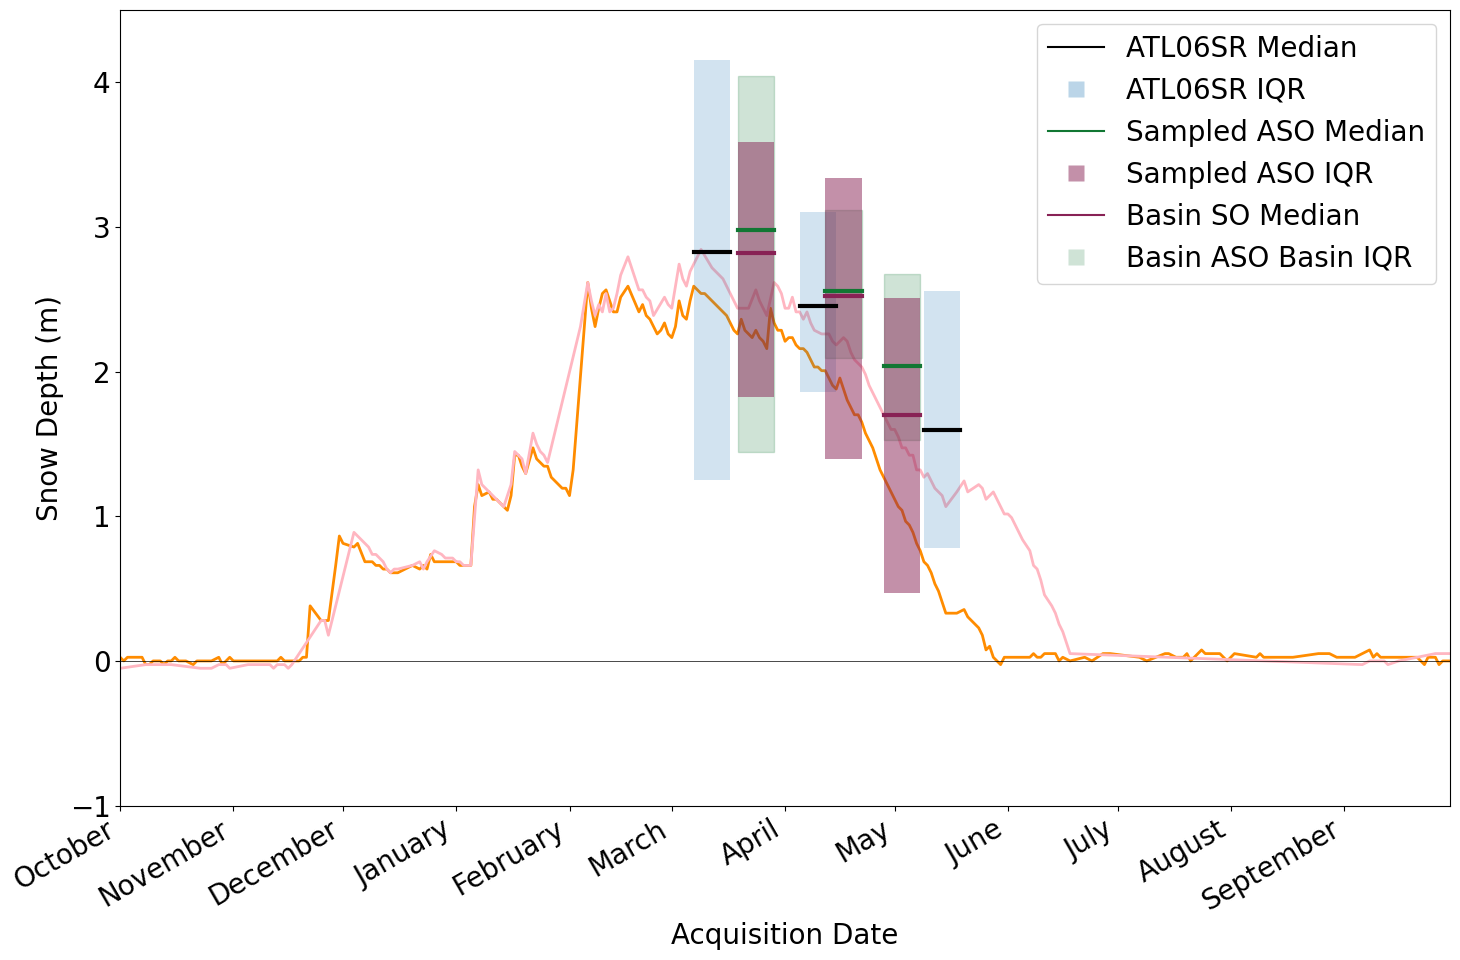

In [52]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4.5), name = 'boxplots_asotracks_basin_2019_paper')

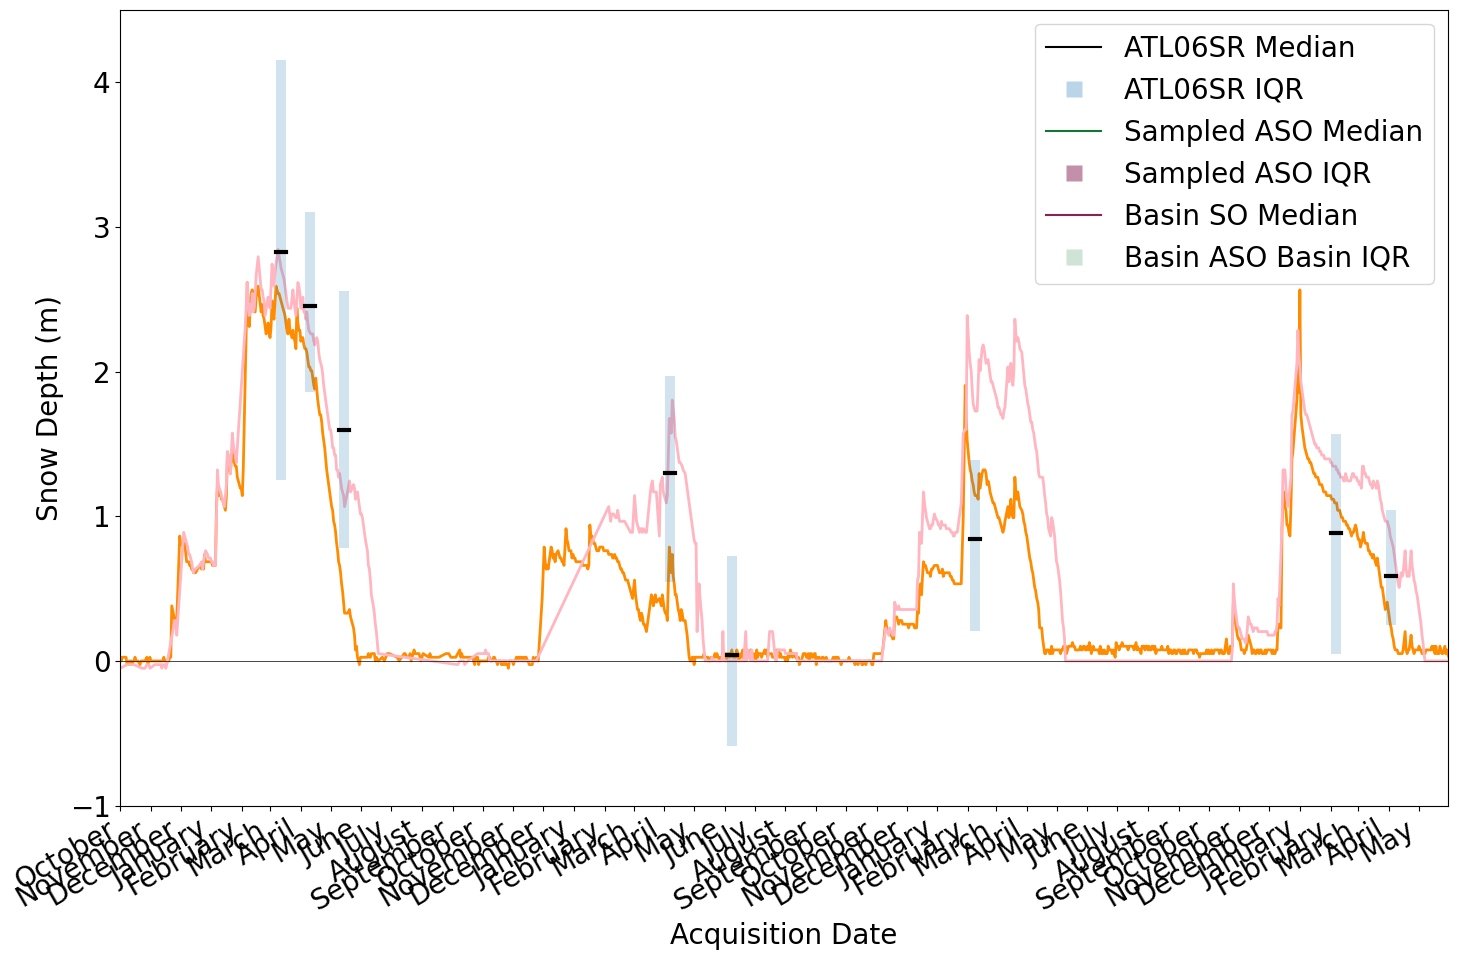

In [53]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus',  clim=(-1,4.5), name = 'boxplots_asotracks_basin_paper')

# Plot Separate Data for Presentation

In [37]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry']

# Function adapted from David Shean by Hannah Besso
# No transparency

def boxplot_date_aso_all(df=None, col=None, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    if df != None:
        bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
        bp_stats_list = [i[0] for i in bp_stats.values]
        bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
        bp_alpha_boxes = bp_alpha/bp_alpha.max()
        pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(15,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    if df != None:
        bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                       whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
                       medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
                    medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
                        medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
    if df != None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            patch.set_edgecolor('None')
            #patch.set_facecolor('#3BA795')
            patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('#117733')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('#882255')
            patch.set_edgecolor('none')
            patch.set_alpha(0.5)
            #patch.set_hatch('o')
    ax.legend(custom, custom_labels, loc='upper right') #, fontsize=10
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    # legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    # legend1.set_alpha(1)
    # if rasterstats:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    # elif col_aso != None:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    # else:
    #     legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    # ax.add_artist(legend1)
    # ax.add_artist(legend2)
    
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if df != None:
        for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
            #patch.set_alpha(alpha)
            patch.set_edgecolor('None')
            patch.set_linewidth(0)
        for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
            #patch.set_alpha(alpha)
            patch.set_color('k')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
    #     patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    # if col_aso != None:
    #     # for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
    #     #     patch.set_alpha(alpha)    
    #     for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
    #         #patch.set_alpha(alpha)
    #         patch.set_color('k')  # or deeppink
    #     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    #     # for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
    #     #     patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_xlabel('Acquisition Date')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    #ax.set_title(title) 
     
    months = mdates.MonthLocator()
    ax.format_xdata = mdates.DateFormatter('%B')
    months_fmt = mdates.DateFormatter('%B')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%B-%Y')
    years_fmt = mdates.DateFormatter('%B %Y')
    #ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
    years_fmt = mdates.DateFormatter('%d-%m-%Y')
    #ax.xaxis.set_major_locator(years)
    #ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(months_fmt)
    
    for label in ax.get_xticklabels(which='minor'): #
        label.set(rotation=30, horizontalalignment='right')
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

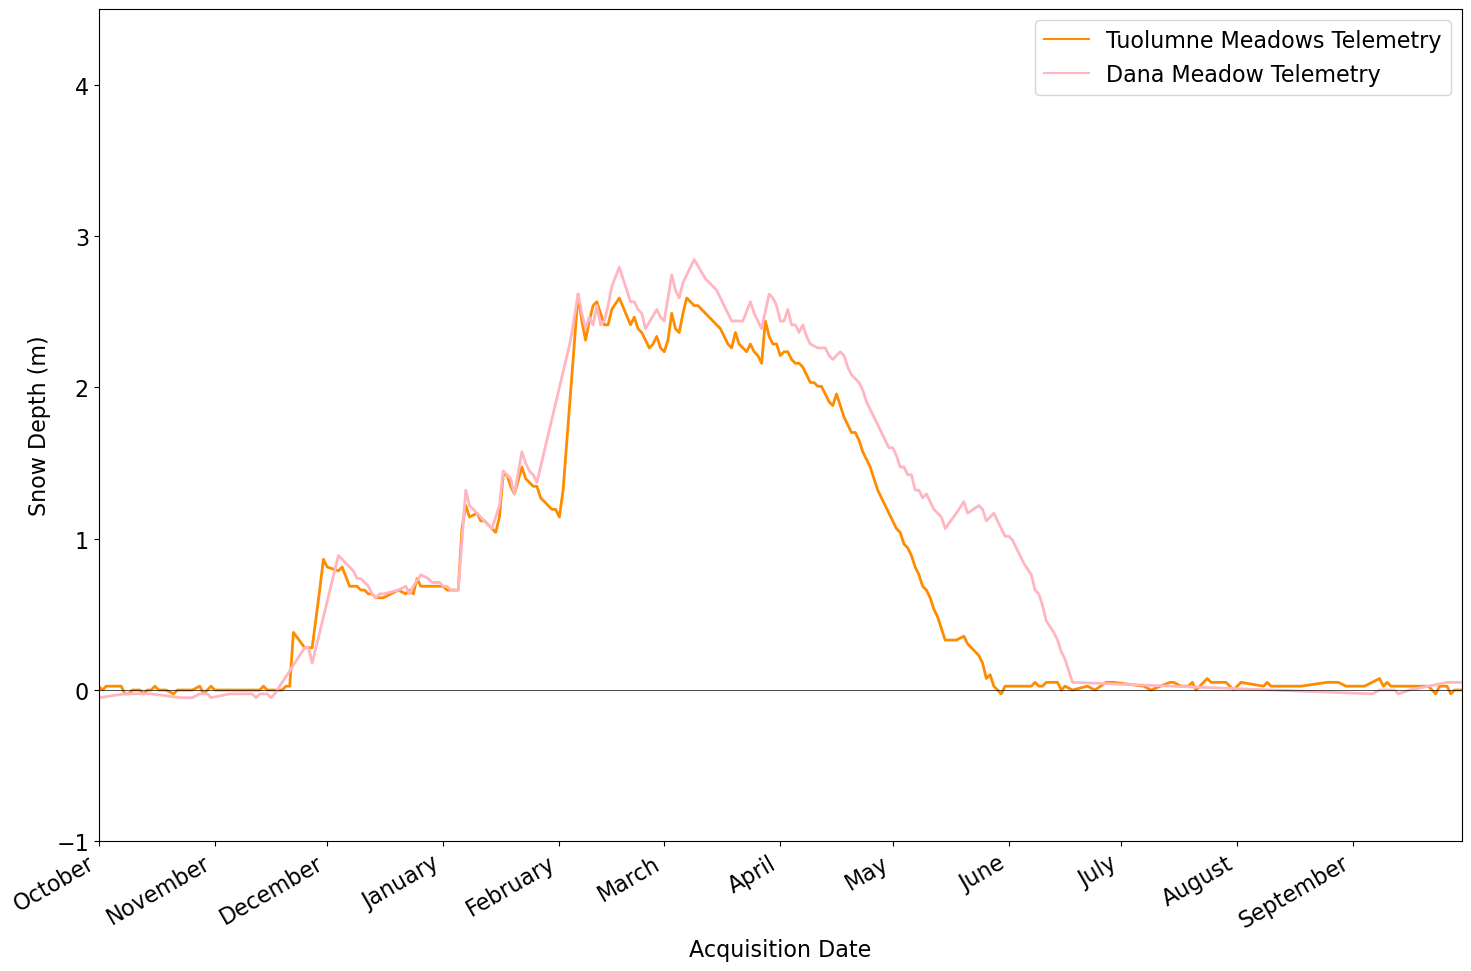

In [39]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(rasterstats=False, clim=(-1,4.5), name = 'boxplots_telemetry_2019_pres')

In [26]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None')]
          
          #Line2D([], [], linestyle='--', color='lightgrey')]
    

custom_labels = ['ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR', 'Basin ALS Median', 'Basin ALS Basin IQR',]

In [83]:


# Function adapted from David Shean by Hannah Besso
# No transparency

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset and ASO basin wide and ASO tracks', name='../figures/boxplots_cdec_aso.jpeg', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(15,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':0.2}, 
                    medianprops={'lw':3, 'c':'#117733'}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':1, 'alpha':1, 'alpha':0.1}, 
                        medianprops={'lw':3, 'c':'#882255'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        #patch.set_facecolor('#3BA795')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('#117733')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('#882255')
            patch.set_edgecolor('none')
            patch.set_alpha(0.5)
            #patch.set_hatch('o')
    ax.legend(custom, custom_labels, loc='upper right') #, fontsize=10
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    # legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    # legend1.set_alpha(1)
    # if rasterstats:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    # elif col_aso != None:
    #     legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    # else:
    #     legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    # ax.add_artist(legend1)
    # ax.add_artist(legend2)
    
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        #patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        #patch.set_alpha(alpha)
        patch.set_color('k')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    # for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
    #     patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    # if col_aso != None:
    #     # for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
    #     #     patch.set_alpha(alpha)    
    #     for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
    #         #patch.set_alpha(alpha)
    #         patch.set_color('k')  # or deeppink
    #     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    #     # for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
    #     #     patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Snow Depth (m)')
    ax.set_xlabel('Acquisition Date')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    #ax.set_title(title) 
     
    months = mdates.MonthLocator()
    months_fmt = mdates.DateFormatter('%B')
    #ax.format_xdata = mdates.DateFormatter('%B')
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_major_formatter(months_fmt)
    #ax.format_xdata = mdates.DateFormatter('%B-%Y')
    #years_fmt = mdates.DateFormatter('%B %Y')
    #ax.xaxis.set_minor_formatter(months_fmt)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%d-%m-%Y')
    years_fmt = mdates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months) 
    
    for label in ax.get_xticklabels(which='minor'): #
        label.set(rotation=30, horizontalalignment='right')
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

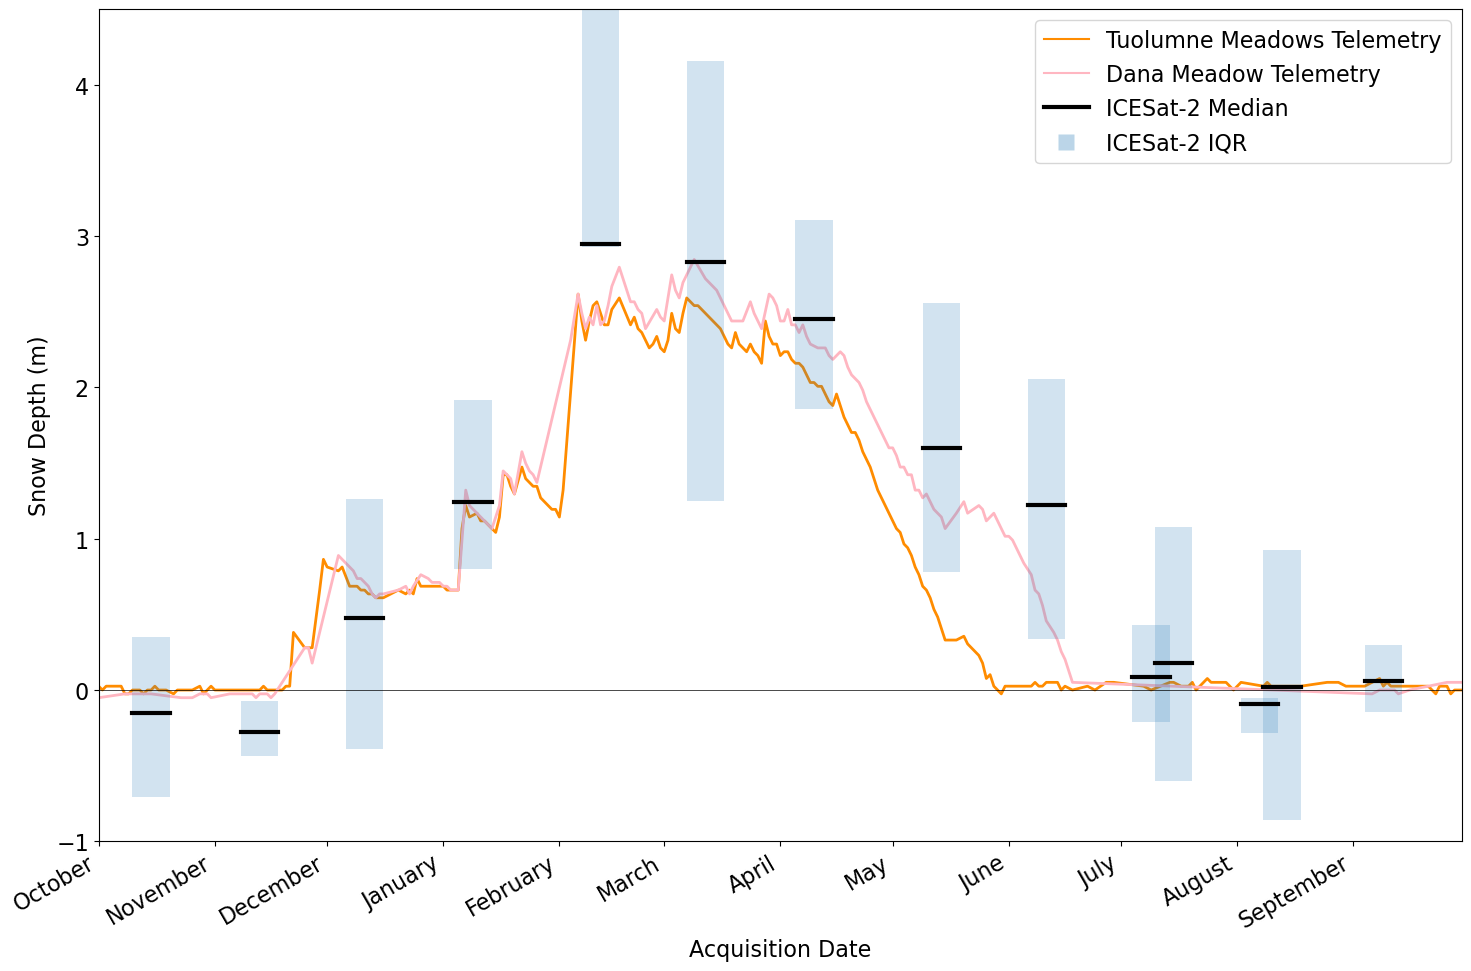

In [54]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          ]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', rasterstats=False, clim=(-1,4.5), name = 'boxplots_atl06sr_telemetry_2019_pres')

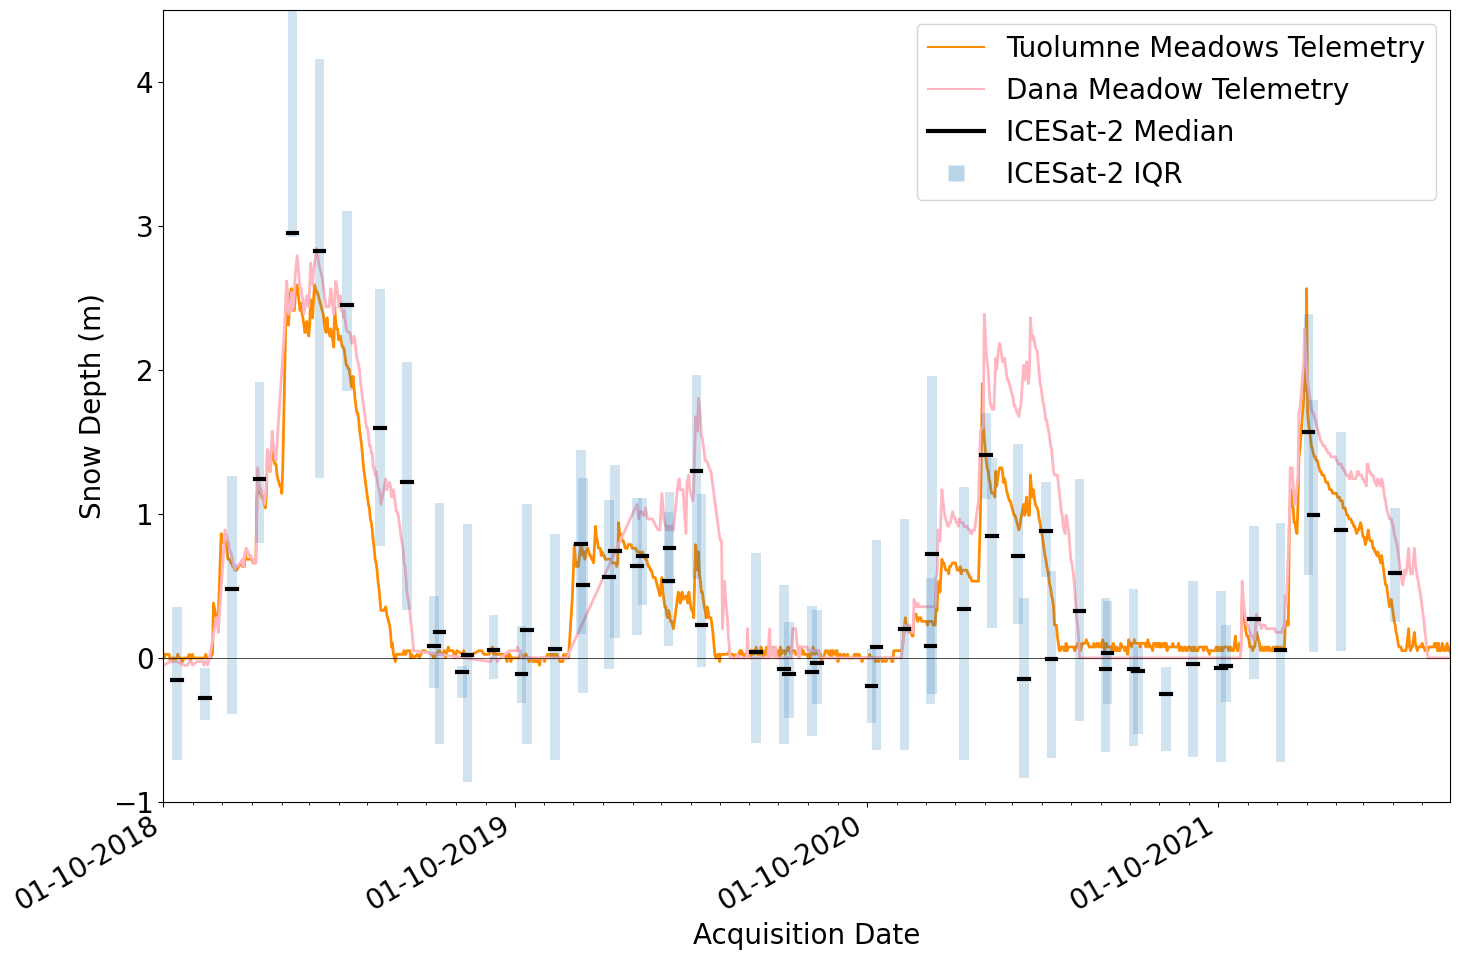

In [84]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          ]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', rasterstats=False, clim=(-1,4.5), name = 'boxplots_atl06sr_telemetry_pres')

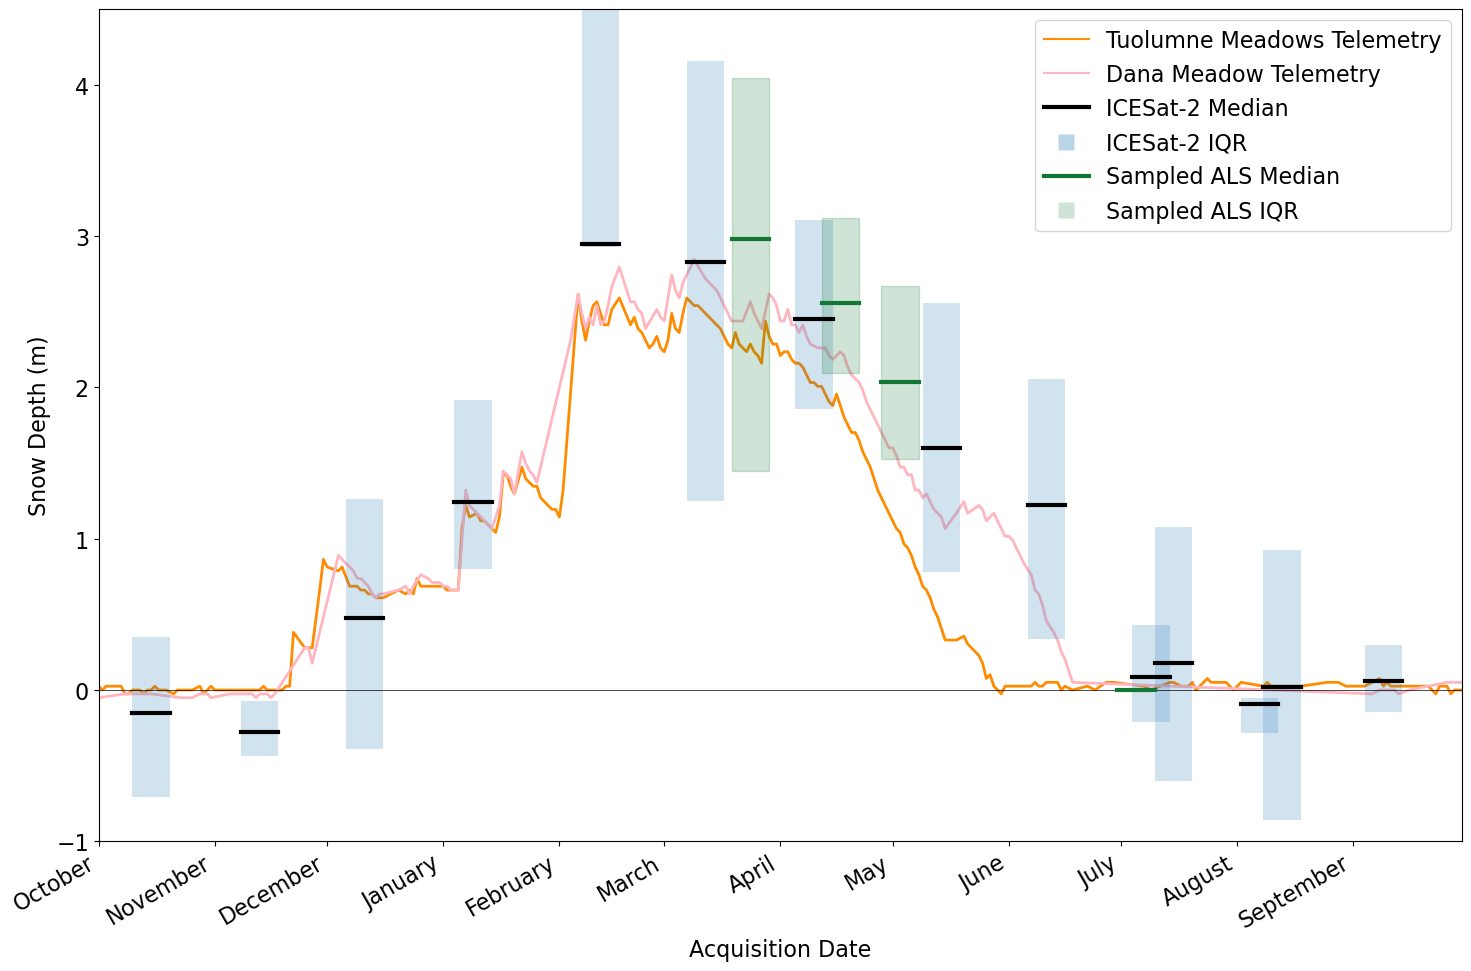

In [52]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          ]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=False, clim=(-1,4.5), name = 'boxplots_als_atl06sr_telemetry_2019_pres')

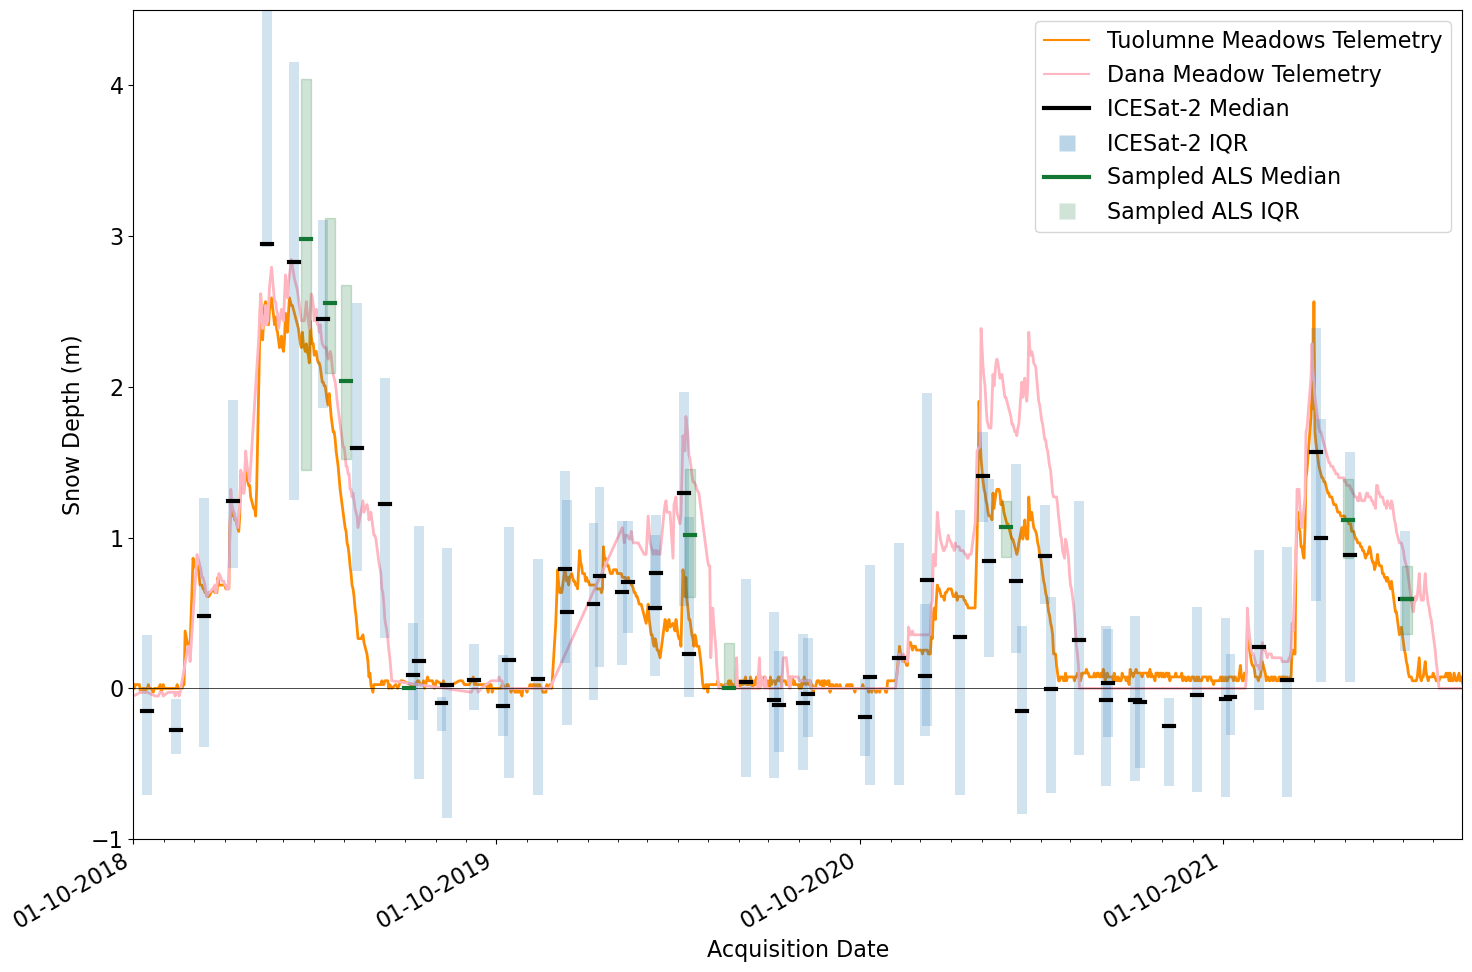

In [63]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          ]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR']
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=False, clim=(-1,4.5), name = 'boxplots_als_atl06sr_telemetry_pres')

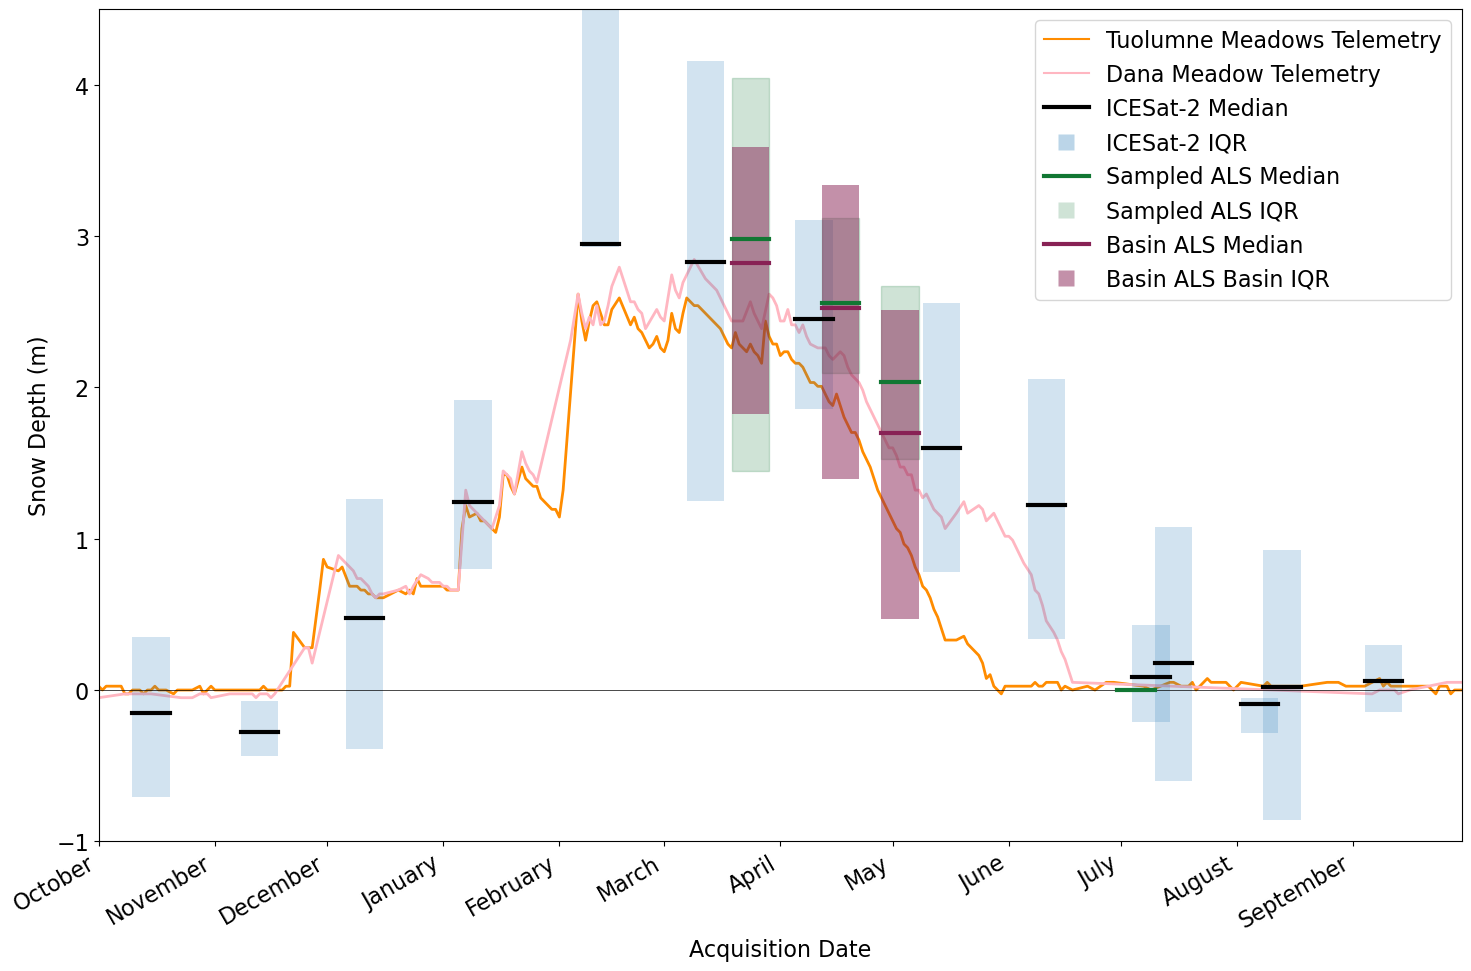

In [57]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None')]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR', 'Basin ALS Median', 'Basin ALS Basin IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4.5), name = 'boxplots_als2_atl06sr_telemetry_2019_pres')

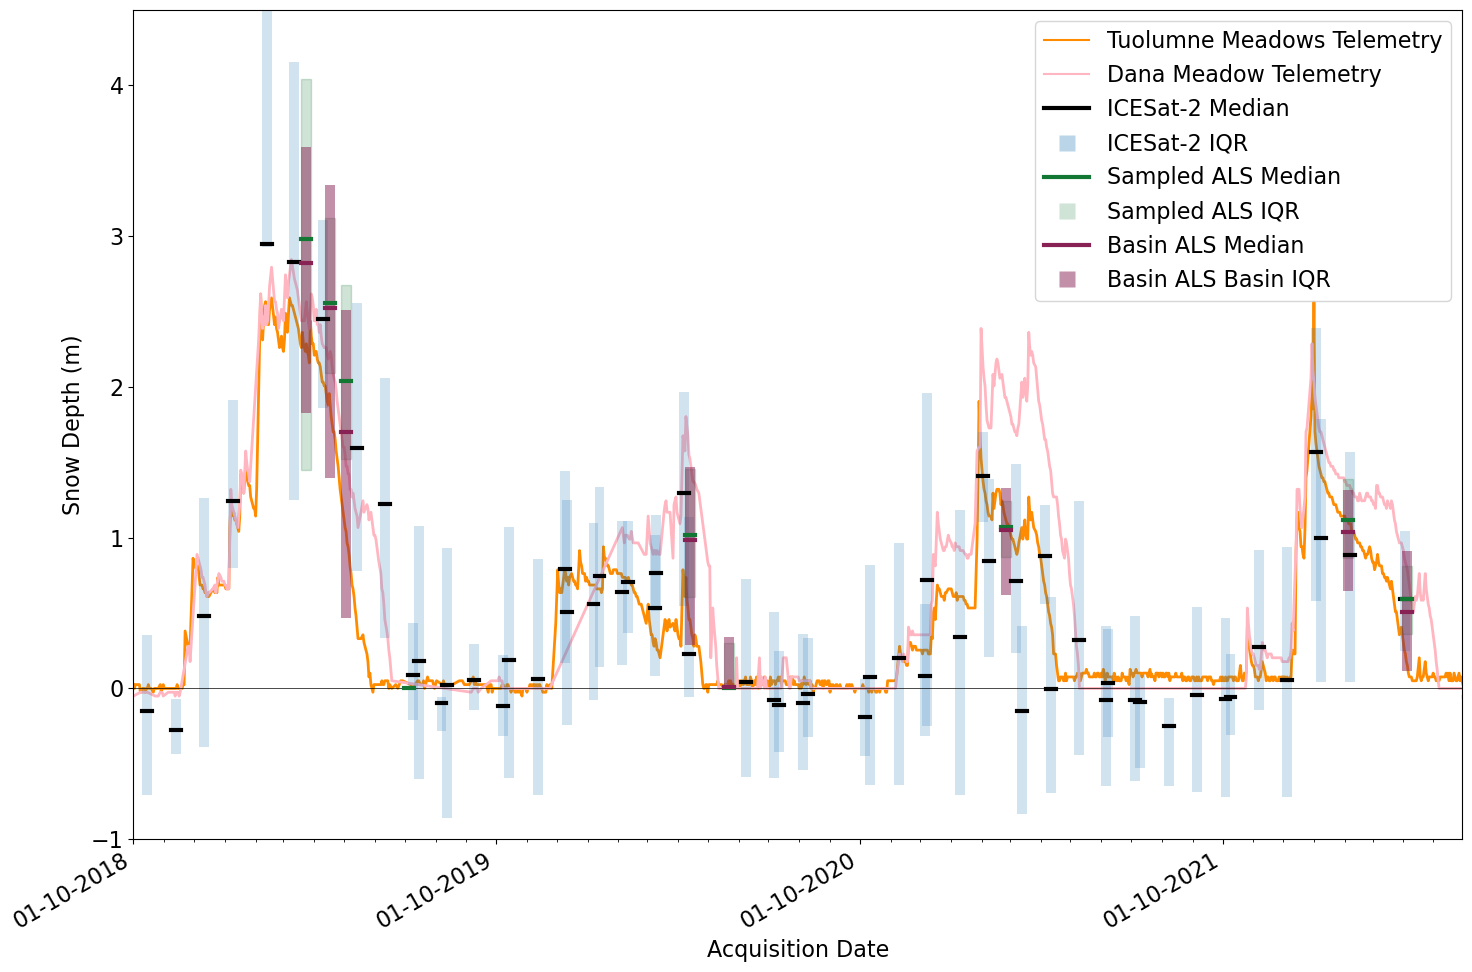

In [65]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='#117733', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(207/255, 227/255, 214/255), linestyle='None'),
          Line2D([], [], linestyle='-', color='#882255', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=(195/255, 144/255, 169/255), linestyle='None')]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ICESat-2 Median', 'ICESat-2 IQR', 'Sampled ALS Median', 'Sampled ALS IQR', 'Basin ALS Median', 'Basin ALS Basin IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4.5), name = 'boxplots_als2_atl06sr_telemetry_pres')

In [183]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


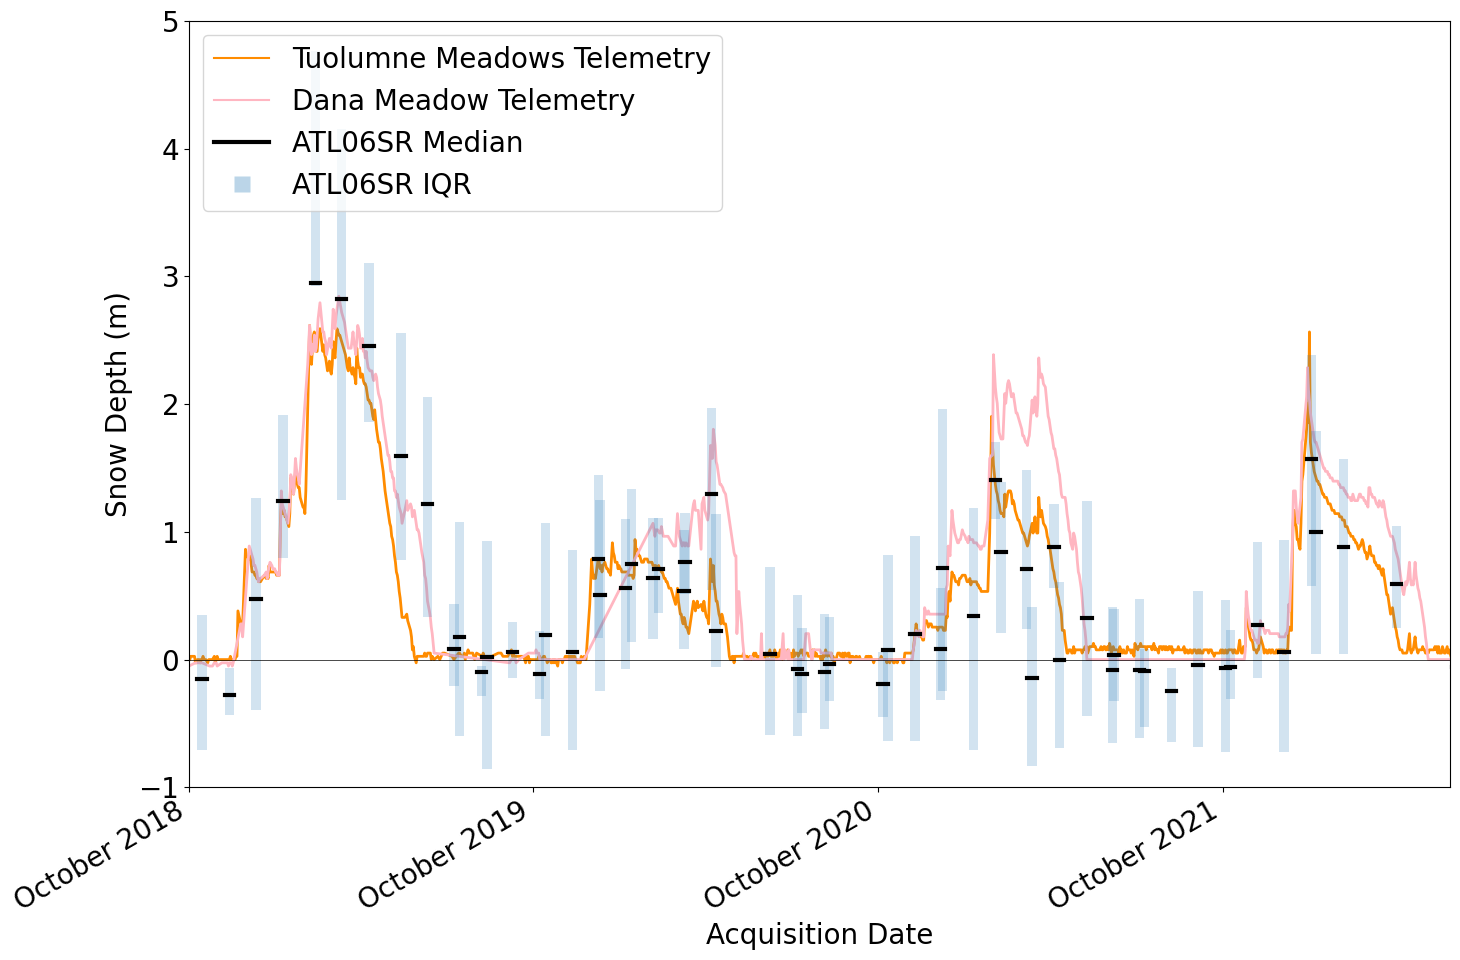

In [93]:
boxplot_color = (31/255,119/255, 180/255, 0.3)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], linestyle='-', color='k', linewidth=3),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          ]
    

custom_labels = ['Tuolumne Meadows Telemetry', 'Dana Meadow Telemetry', 'ATL06SR Median', 'ATL06SR IQR']

dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,5), name = 'boxplots_atl06sr_paper')

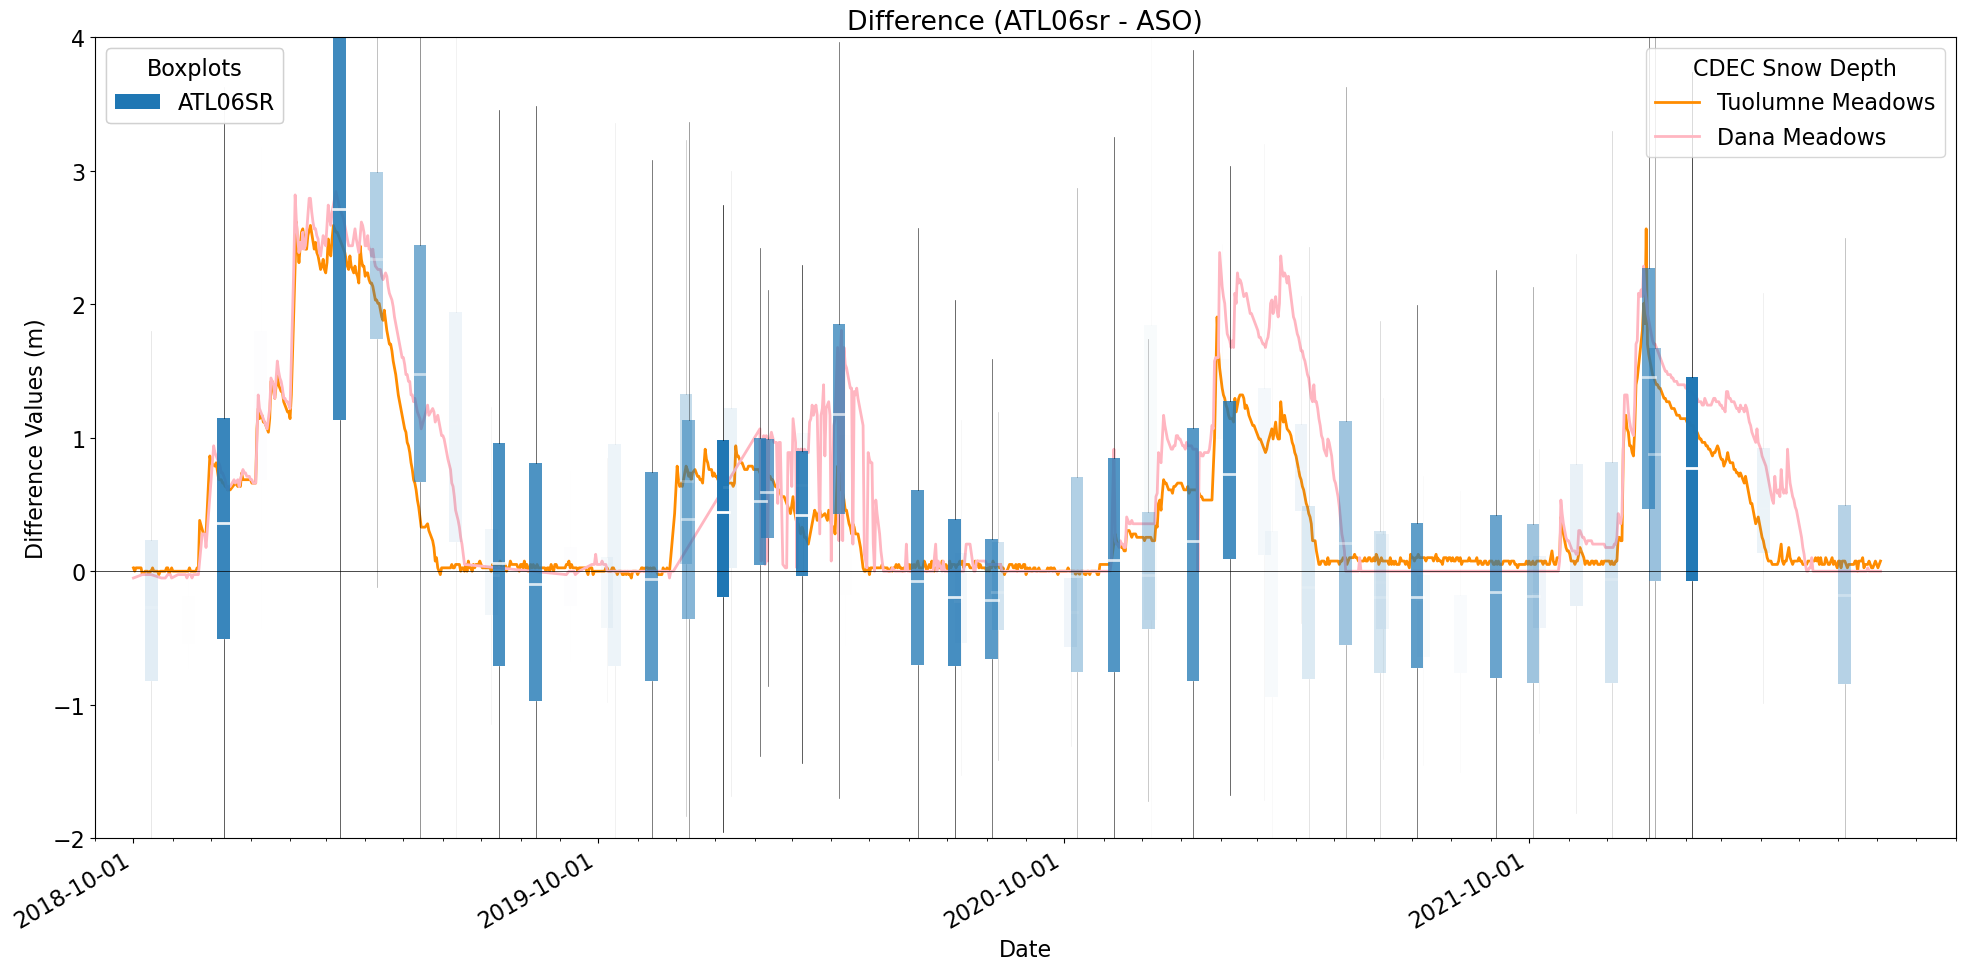

In [184]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,4), title='Difference (ATL06sr - ASO)', name = 'boxplots_difference.jpeg')

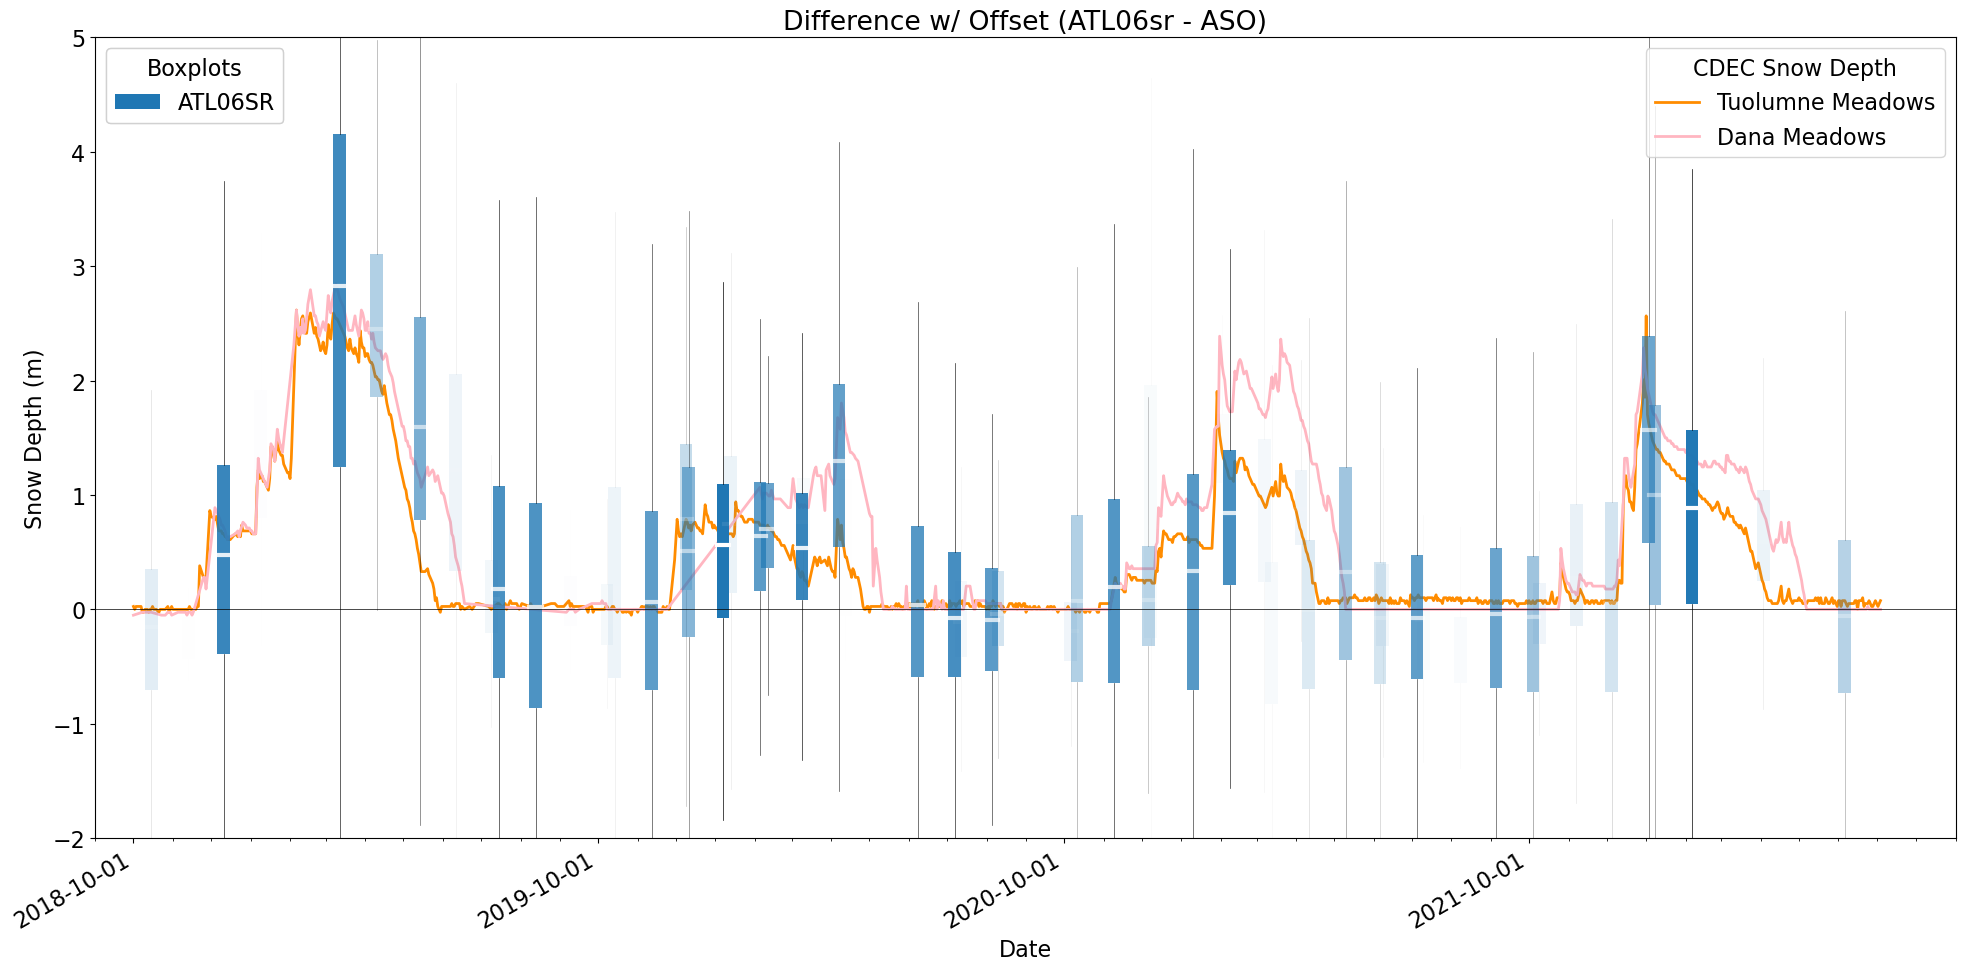

In [273]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', clim=(-2,5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus.jpeg')

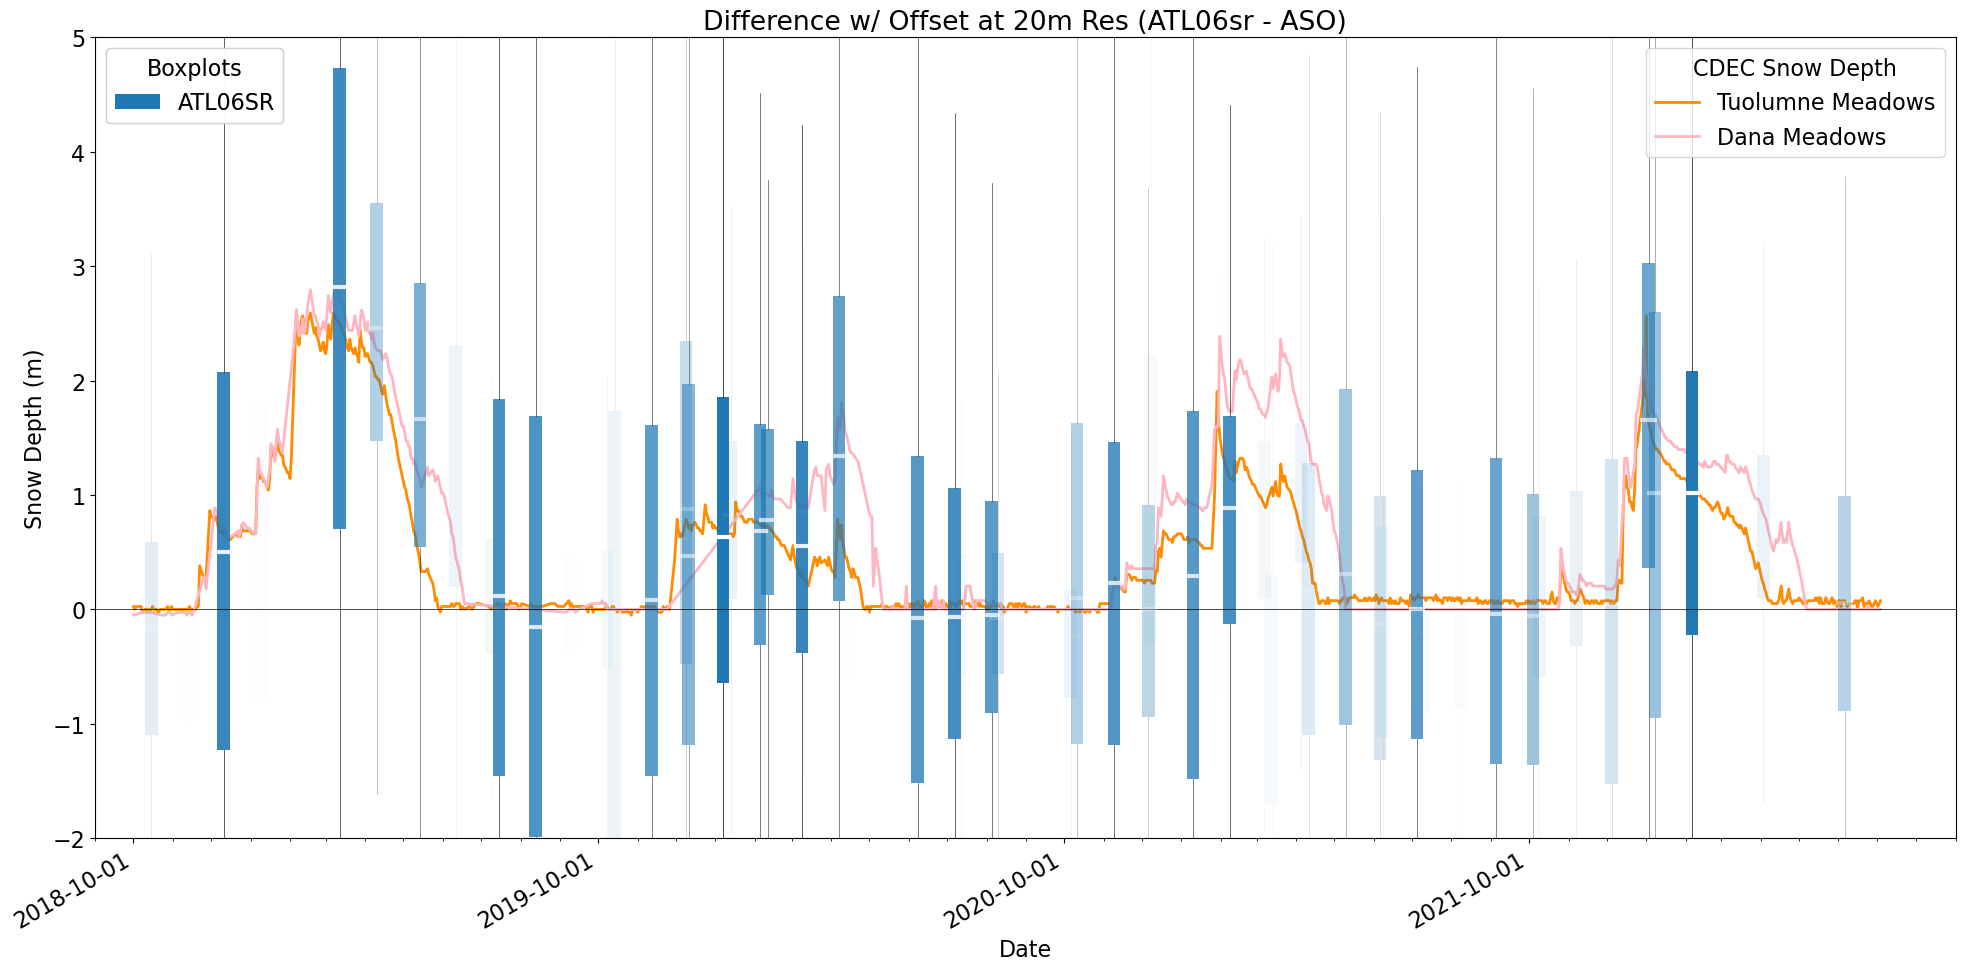

In [274]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-2,5), title = 'Difference w/ Offset at 20m Res (ATL06sr - ASO)', name = 'boxplots_diffplus_20m.jpeg')

### Transparent boxplots with ASO Snow-On Data

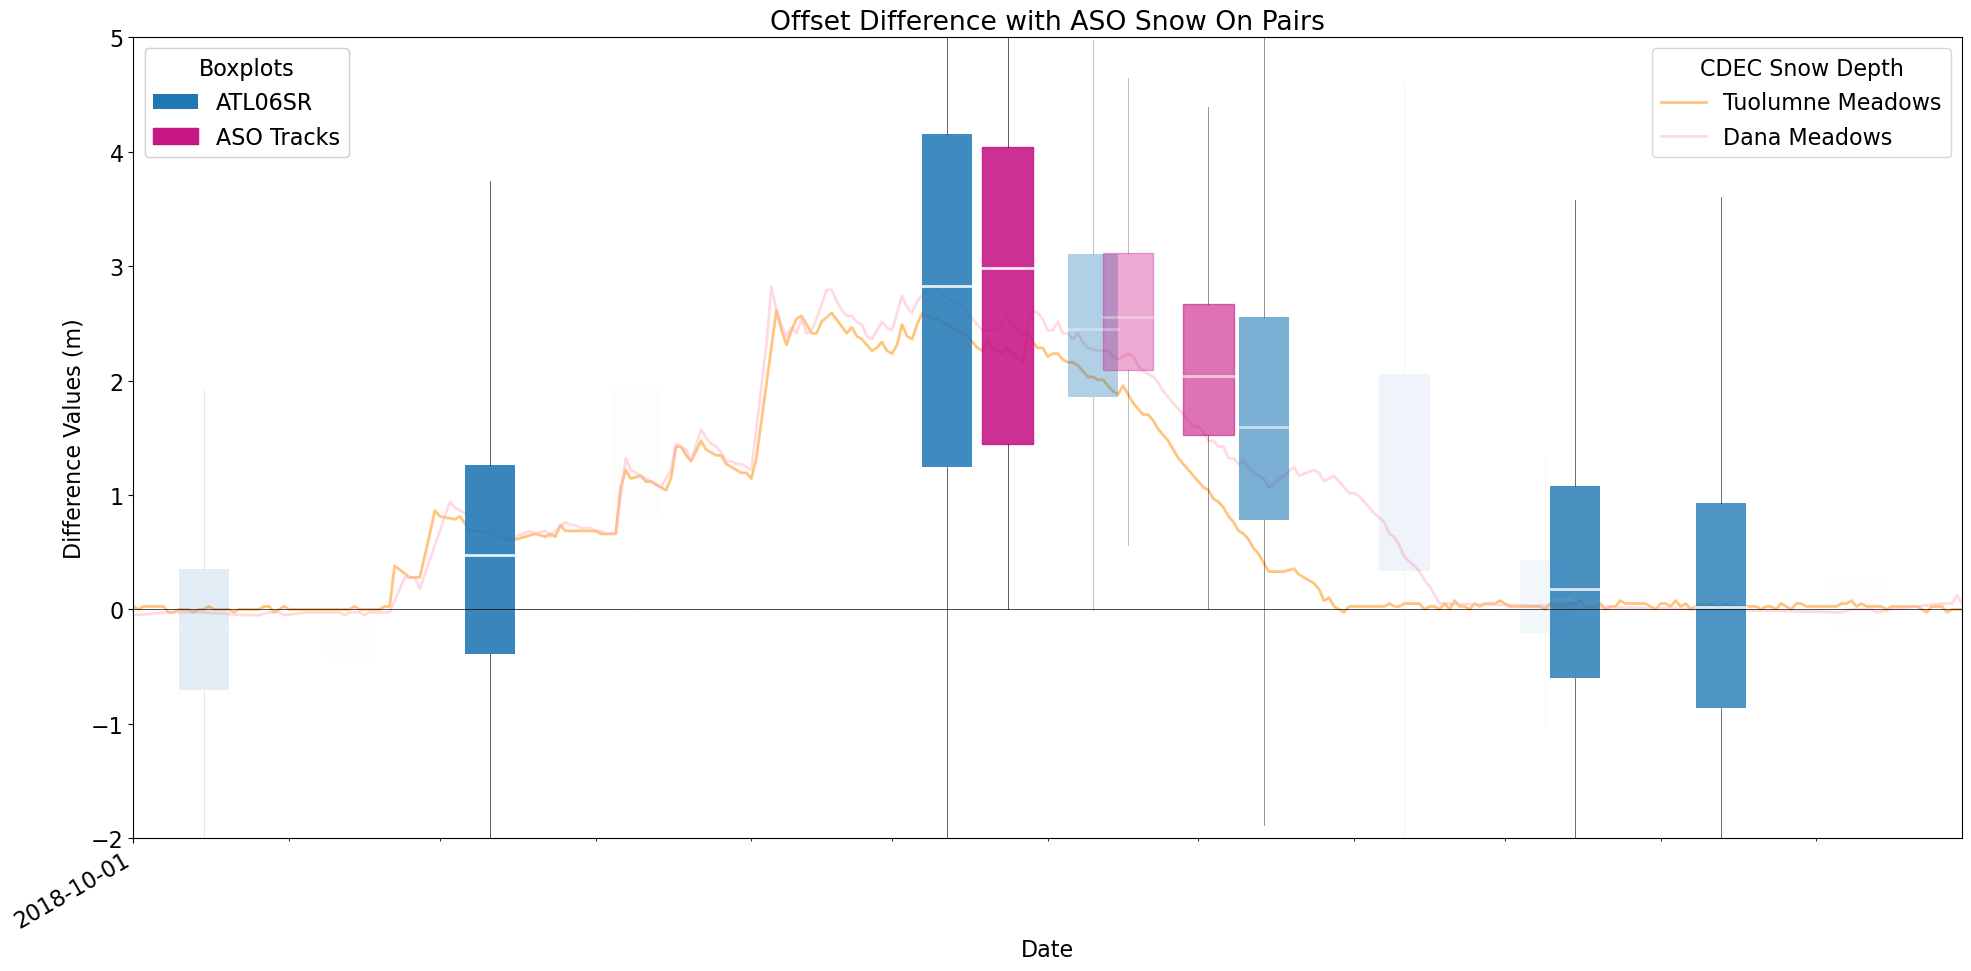

In [170]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Offset Difference with ASO Snow On Pairs', name = 'boxplots_asotracks_2019.jpeg')

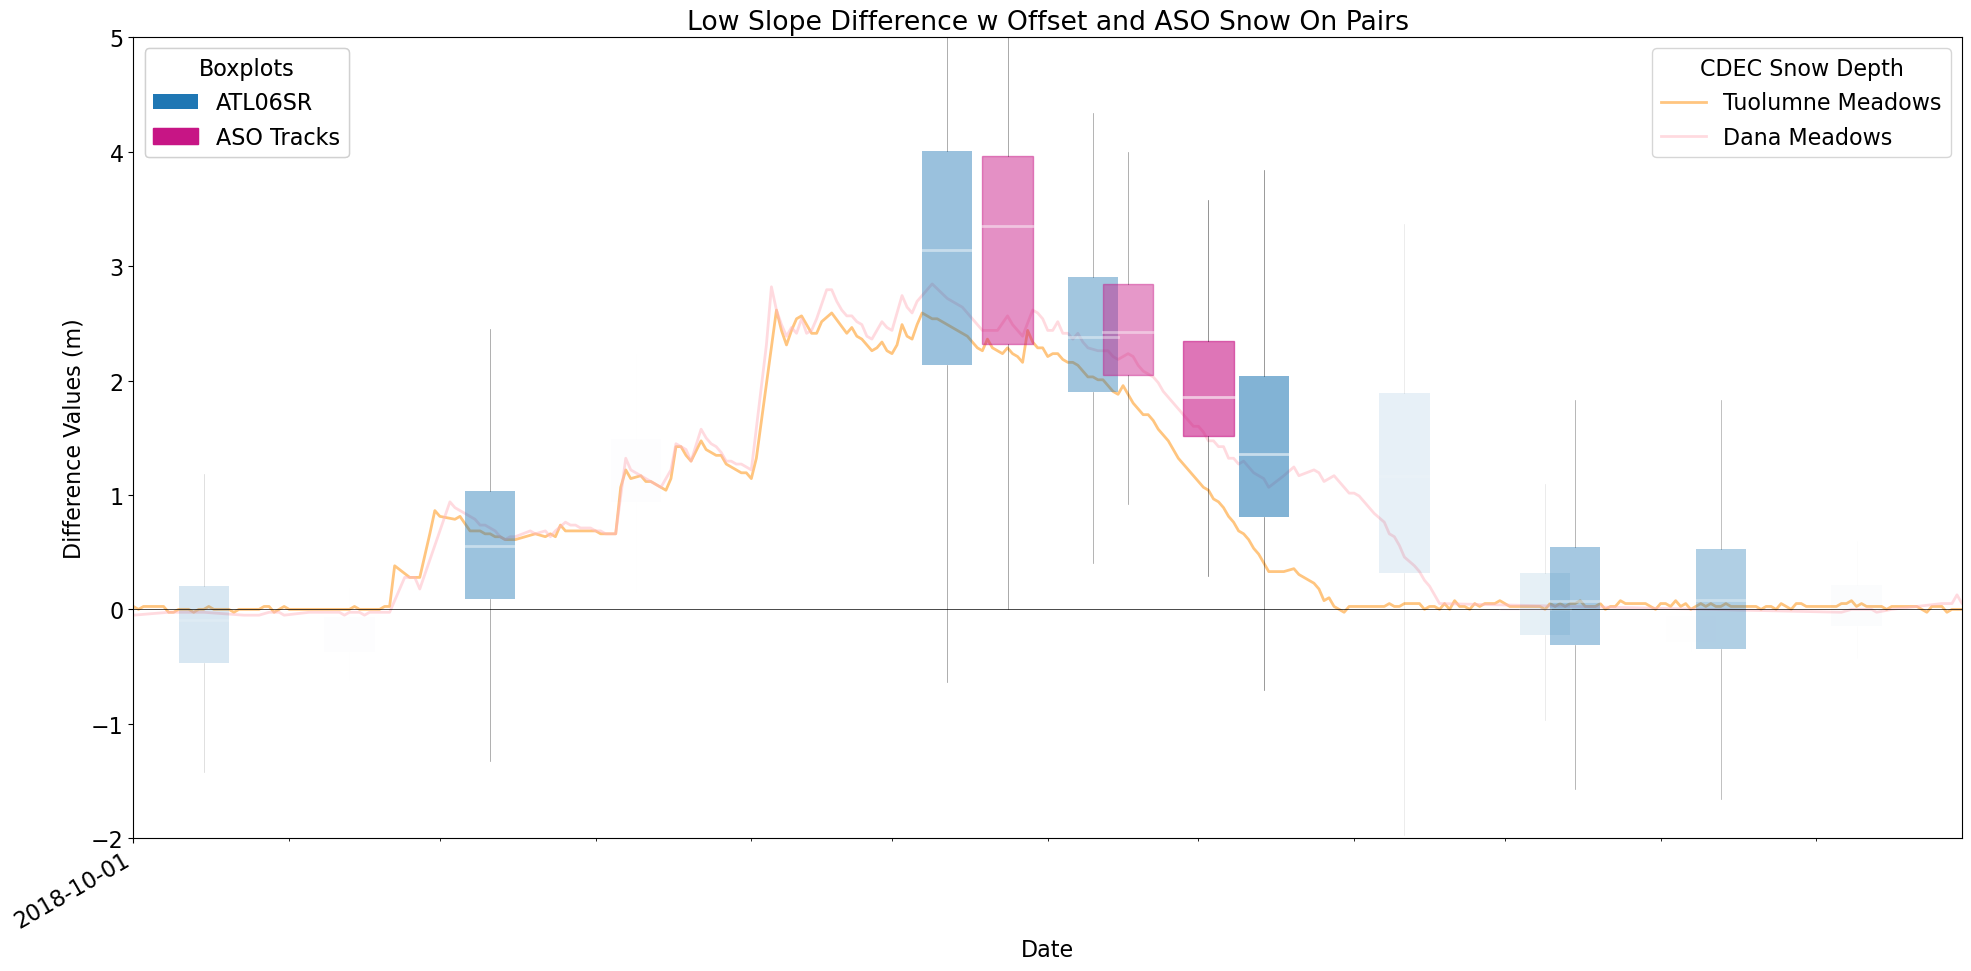

In [171]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_2019_lowslope.jpeg')

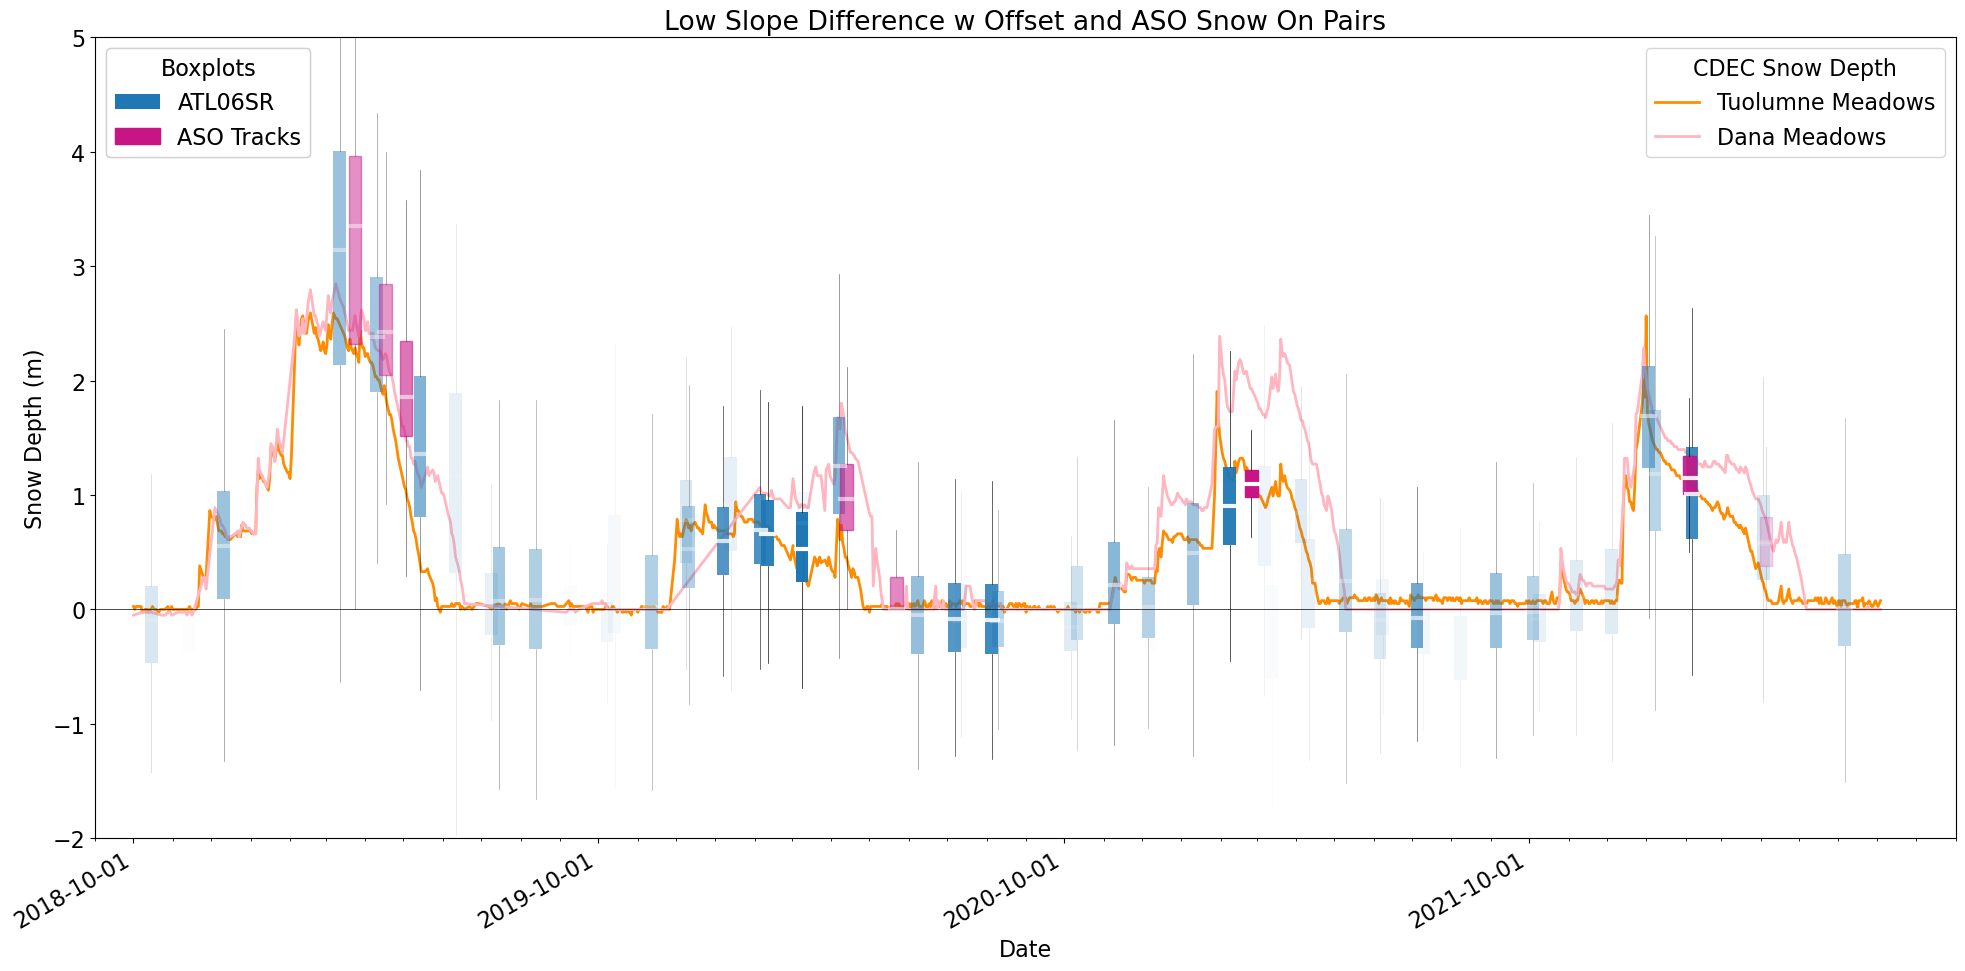

In [275]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_lowslope.jpeg')

## Transparent Boxplots with ASO Snow-On at ATL06SR and Entire Basin

#### Use rasterstats to make boxplots of ASO data for the Study area

In [26]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-2,6), name = 'boxplots_asotracks_basin_2019.jpeg')

NameError: name 'stats_dict' is not defined

### Look at all years of data:

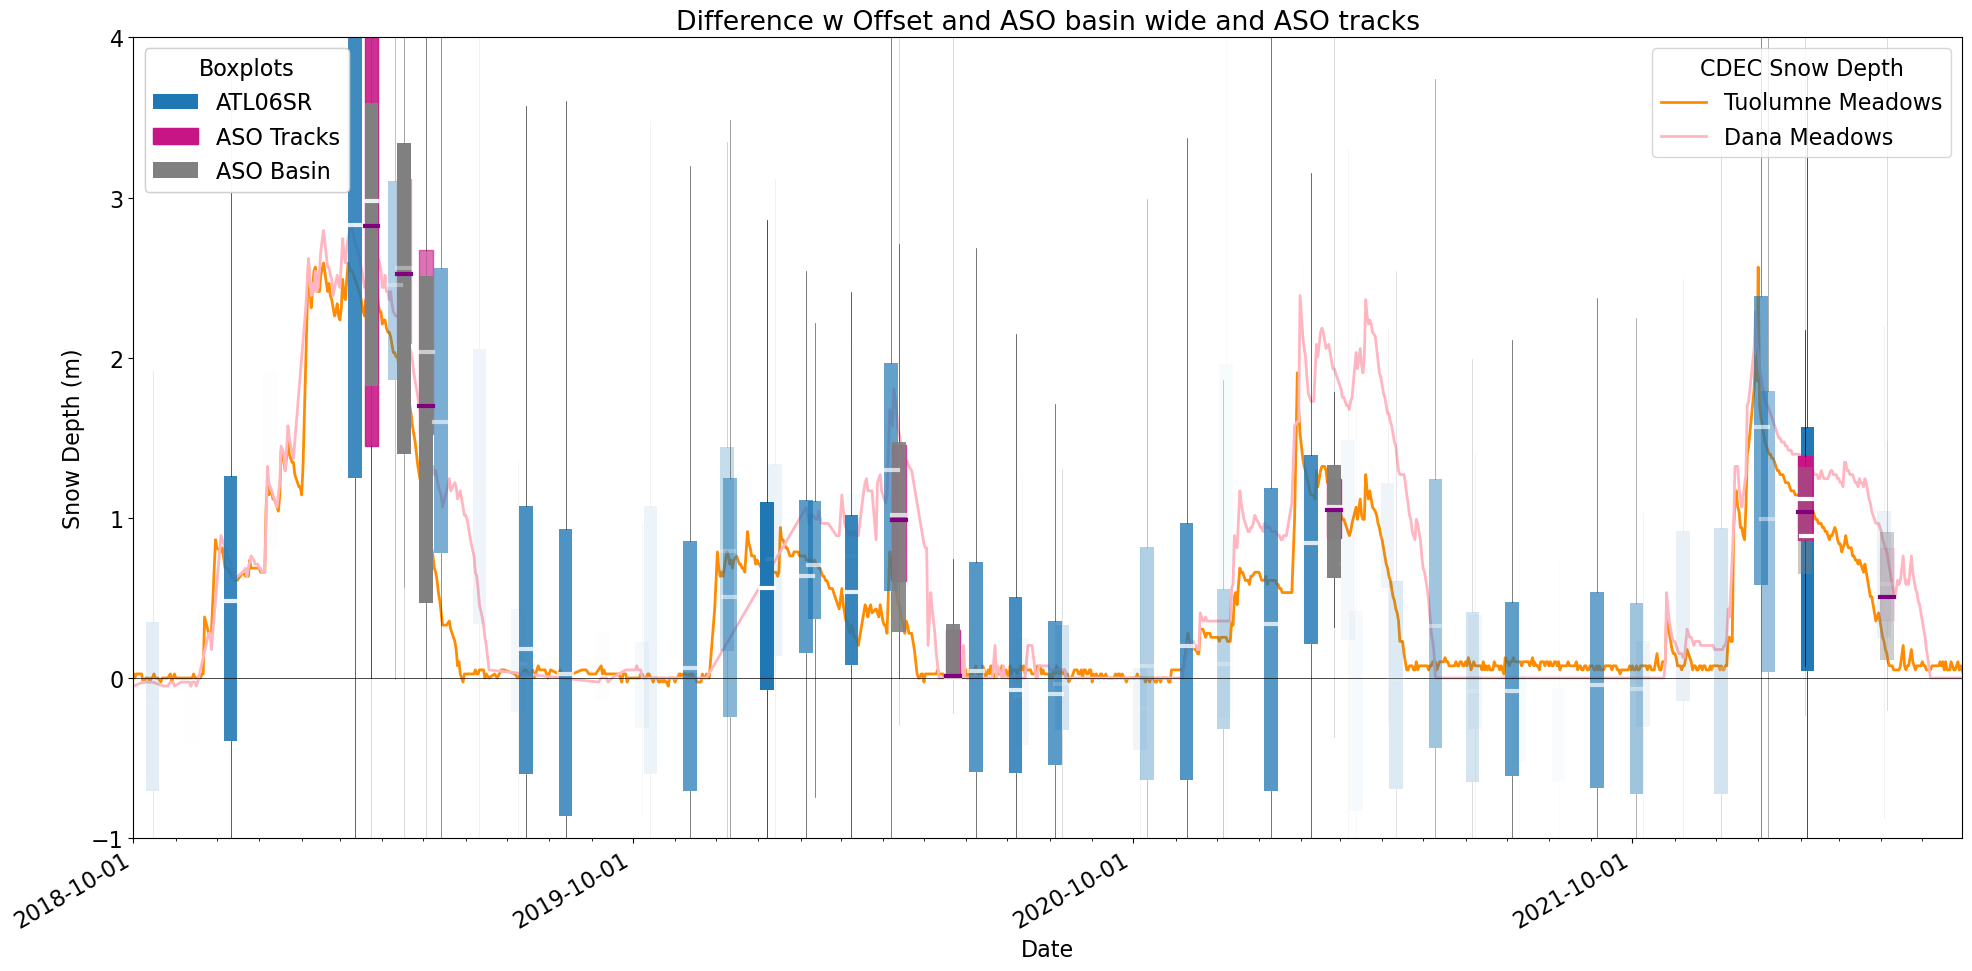

In [22]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=True, clim=(-1,4), name = 'boxplots_cdec_aso_allyears.jpeg')

## Look at only ATL06SR and ASO Temporal Pairs

In [153]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2019, 7, 9),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

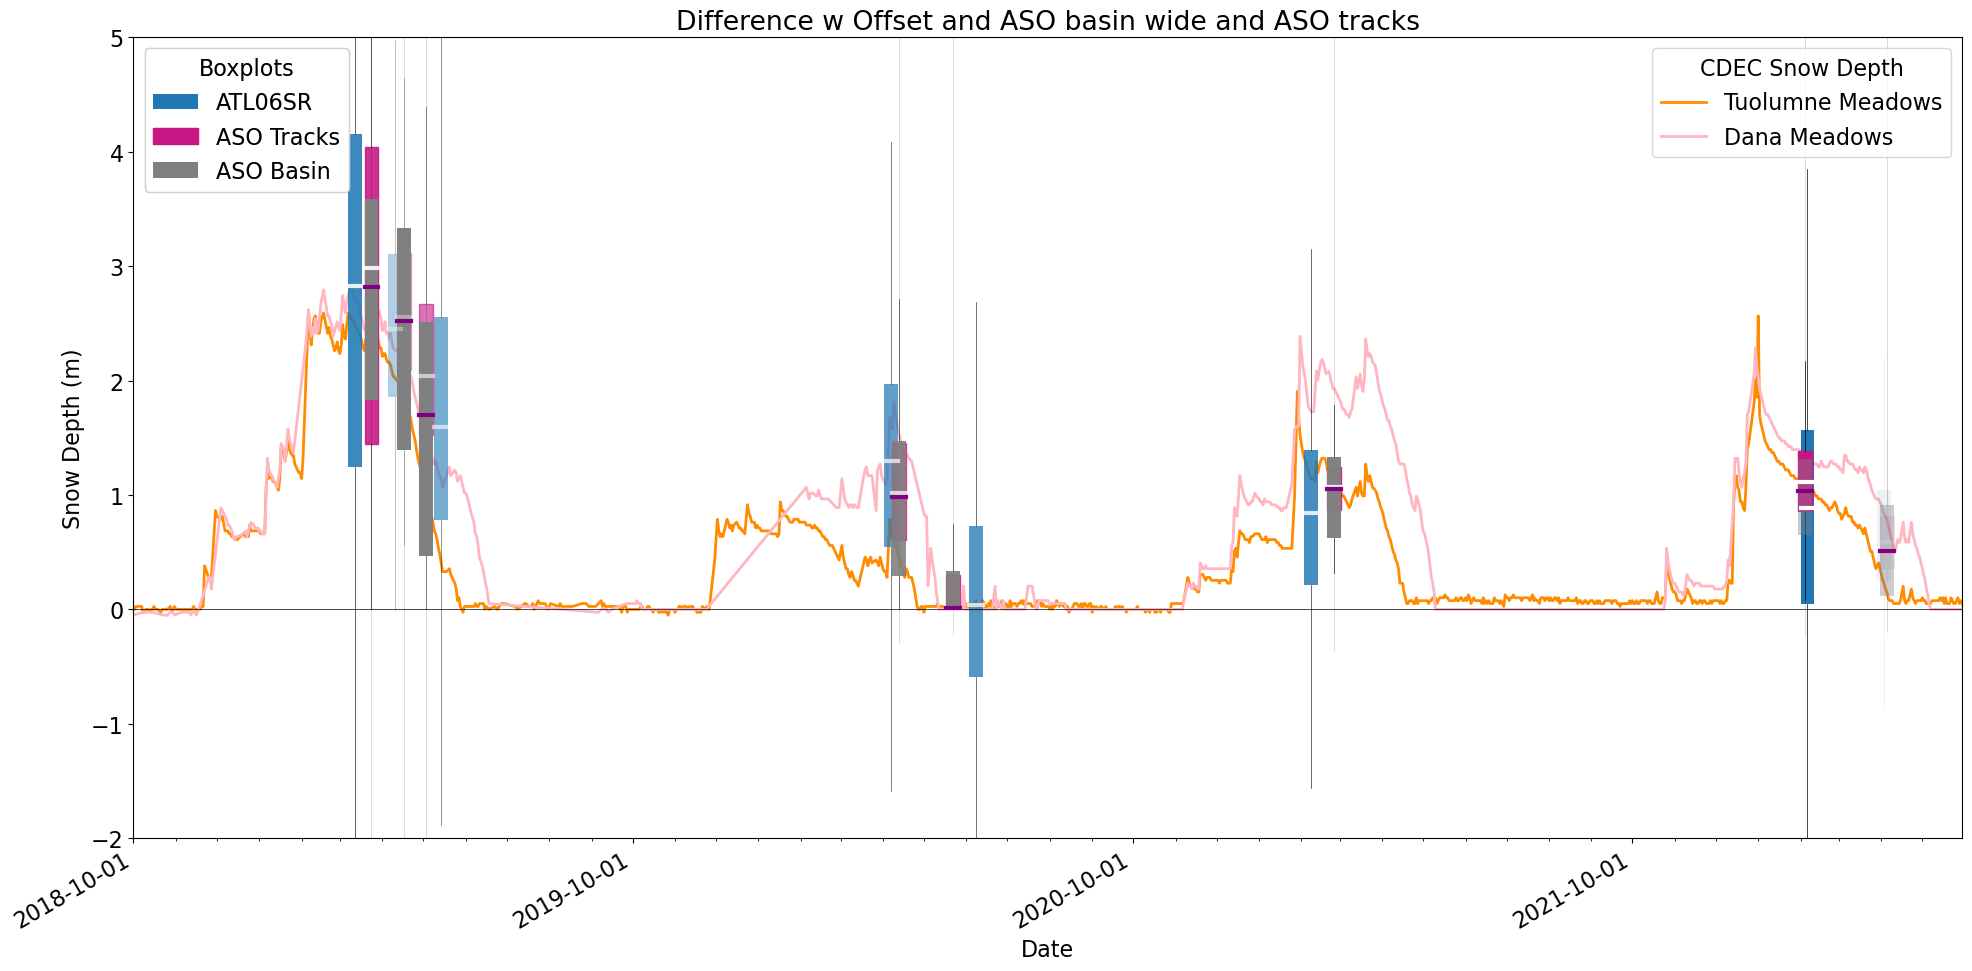

In [23]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=True, name = 'boxplots_asotracks_basin.jpeg')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

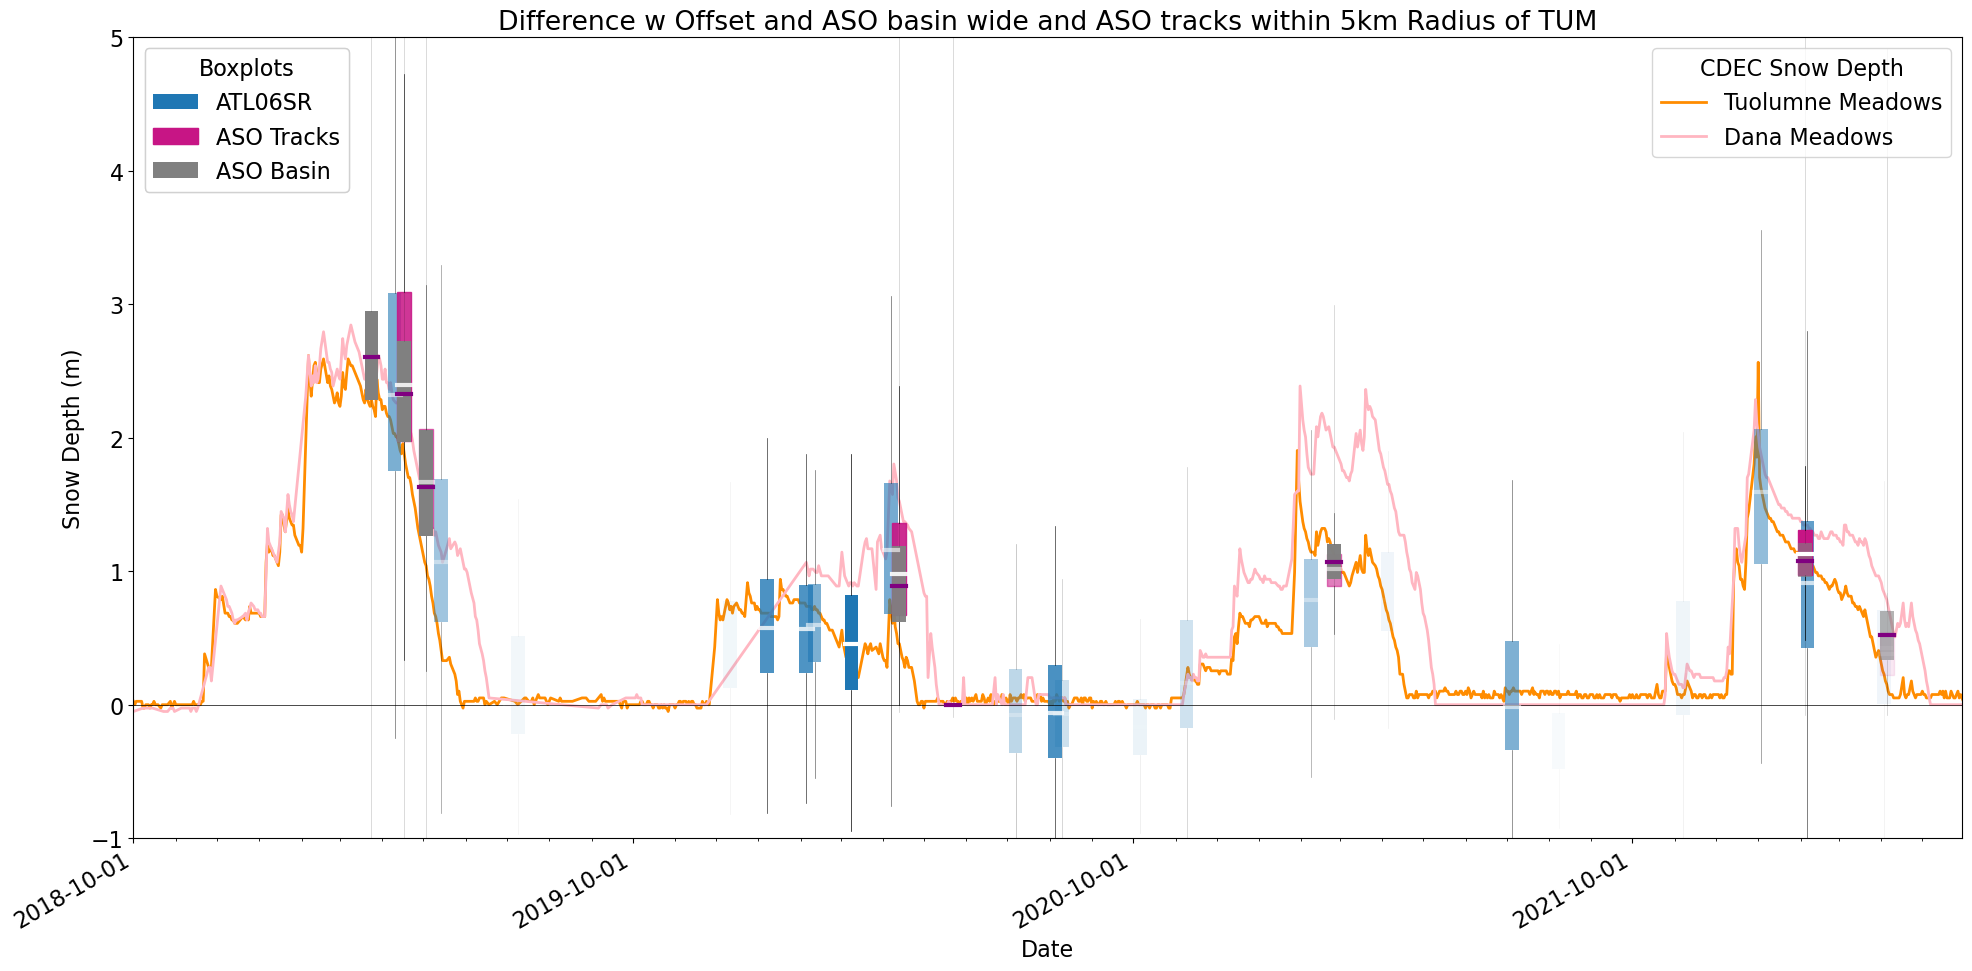

In [24]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[2, 'geometry'], rasterstats=True, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = 'boxplots_asotracks_basin_tum5.jpeg')

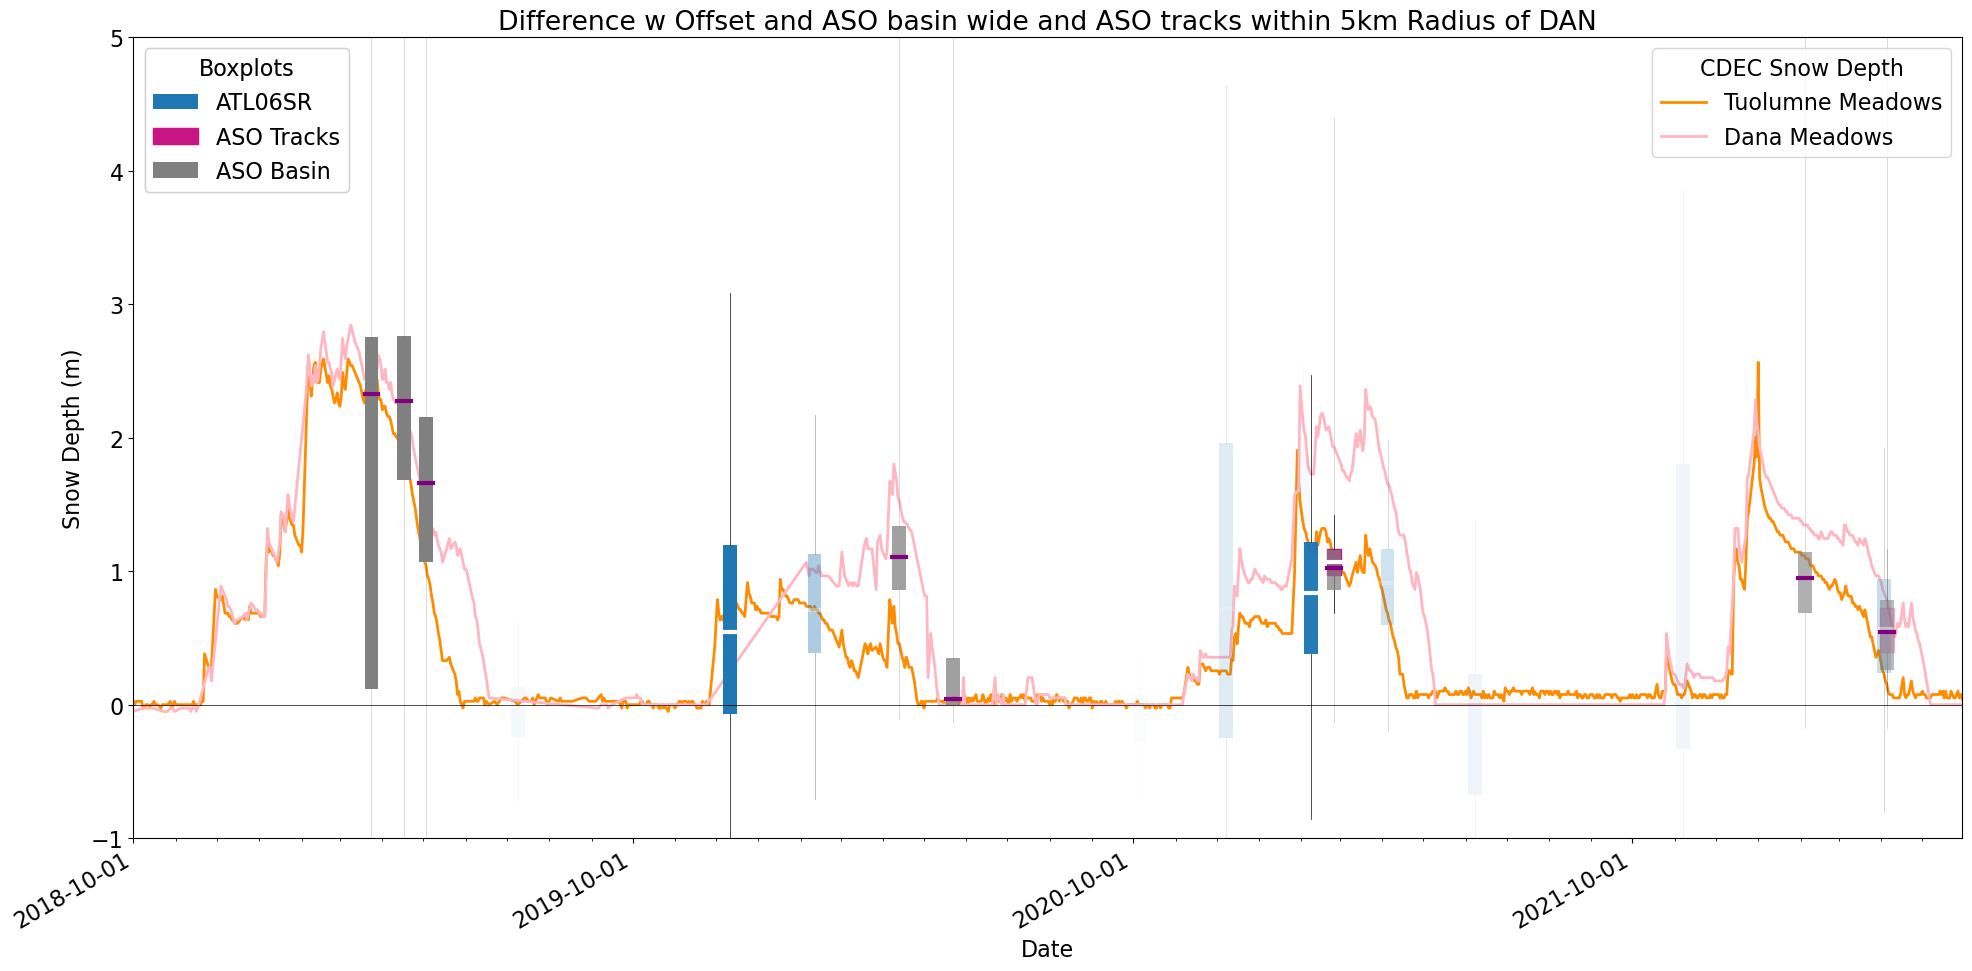

In [25]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=True, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = 'boxplots_asotracks_basin_dan5.jpeg')

## Old, less universal plotting functions:

In [157]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [158]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)